# 0. DOWNLOAD PACKAGES

In [1]:
import os
import sys
import math
import random
import pickle
import warnings
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from bisect import bisect_left
from itertools import combinations
from math import sqrt

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import MonthEnd
from matplotlib.patches import Rectangle

from scipy import stats
from scipy.stats import (norm, skew, kurtosis, pearsonr, spearmanr, kendalltau)
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error
import pysal
from numpy.random import Generator, PCG64
from functools import partial


file = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/"

import sys
sys.path.append(file)

import nbimporter
import FUNCTION_LIST as ChatJR # This will import all top-level functions/definitions from the notebook

import inspect
import openpyxl
warnings.filterwarnings("ignore")

## 0.1 LIST ALL MY FUNCTIONS

In [2]:
import inspect

# List all functions defined in the imported notebook
functions_list = [name for name, obj in inspect.getmembers(ChatJR) if inspect.isfunction(obj)]
functions_list

['Converters',
 'Correct_Pres',
 'Correct_Pres_1_col_Only',
 'Correct_Temp',
 'Document',
 'Linear_Regression_Equations',
 'OxmlElement',
 'Perth_Combination',
 'Reduce_to_MSLP_V2_2',
 'SD_Y_WMO_GL',
 'STORM_MSLP_ONLY',
 'STORM_V2',
 'Storm_Finder_AP_2009',
 'Storm_Finder_With_Rain',
 'TO_MSLP',
 'TO_SP',
 'UQC_pres_formats',
 'WMO_Guide_Months',
 'WMO_Guide_Yearly',
 'c_to_f',
 'calculate_gravity',
 'corr_sig',
 'curve_fit',
 'f_to_c',
 'filter_dataframe_by_months',
 'get_ipython',
 'kendalltau',
 'kurtosis',
 'linear_regression_polyfit',
 'mean_squared_error',
 'pearsonr',
 'qm_transfer',
 'qn',
 'rh_fmt_row_day_mean',
 'rh_fmt_row_month_mean_all',
 'rh_fmt_row_month_mean_via_WMO_Guide',
 'rolling_cross_correlate',
 'running_correlation_with_p',
 'save_to_word',
 'skew',
 'spearmanr',
 'ymd_column']

# 1. DOWNLOAD ALL NECESSARY DATA

## 1.1 PERTH 1830-2024

### 1.1.1 PRESSURE

In [3]:
'''MSLP'''
'''OVERALL PERTH PRESSURE DATASETS Pressure'''
P_MSLP_SD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_SUBDAILY_1830-2024.csv").set_index('Date')
P_MSLP_SD.index= pd.to_datetime(P_MSLP_SD.index,format='mixed',dayfirst = False)
#Since we are only looking at 9am and 3pm we want that data only
P_MSLP_93 = pd.concat([P_MSLP_SD[P_MSLP_SD.index.hour ==9],P_MSLP_SD[P_MSLP_SD.index.hour ==15]],axis = 0).sort_index()

#Using WMO guidelines, produce the Pressure values from SD->D->M->Y
P_MSLP_93 = ChatJR.SD_Y_WMO_GL(P_MSLP_93,'Date','MSLP',False)
P_MSLP_SD = P_MSLP_93[0]

#We need to infil the 1876-79 period of monthlies and yearlies
#Download my Monthly dataset
P_MSLP_M = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_MONTHLY_1830-2024.csv").set_index('Date')
P_MSLP_M.index= pd.to_datetime(P_MSLP_M.index,format='mixed',dayfirst = False)
#Download my Yearly dataset
P_MSLP_Y = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_CORRECTED_YEARLY_1830-2024.csv").set_index('Date')
P_MSLP_Y.index= pd.to_datetime(P_MSLP_Y.index,format='mixed',dayfirst = False)

#Just filling in the data where Subdaily is missing
P_MSLP_M = pd.concat([P_MSLP_93[2].loc[:'1875'],P_MSLP_M.loc['1876':'1879'],P_MSLP_93[2].loc['1880':]],axis = 0).sort_index()
P_MSLP_Y = pd.concat([P_MSLP_93[3].loc[:'1875'],P_MSLP_M.loc['1876':'1879'].resample('YS').mean(),P_MSLP_93[3].loc['1880':]],axis = 0).sort_index()

P_MSLP = [P_MSLP_SD.round(1),P_MSLP_SD.resample('D').mean().round(1),P_MSLP_M.round(1),P_MSLP_Y.round(1)]

### 1.1.2 RAINFALL AND RAINDAYS

In [4]:
#PERTH METRO
PM_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_RAINFALL_BOM_DAILY_1993-2025.csv")
# Convert Year, Month, Day into a single Date column
PM_RD['Date'] = pd.to_datetime(PM_RD[['Year', 'Month', 'Day']])
#Convert to rainfall and index as date
PM_RD['RAINFALL'] = PM_RD['Rainfall amount (millimetres)']
#Set index date
PM_RD = PM_RD.set_index('Date')

#Drop all dates where rainfall data was actually not recorded as they are recorded as NaN
PM_RD = PM_RD[['RAINFALL']].dropna()

#Rename 'Period over which rainfall was measured (days)' to 'RAINDAYS' andd make it a rain day if it rained over 0.4mm
PM_RD['RAINDAYS'] = PM_RD['RAINFALL'].apply(lambda x: 1 if x > 0.4 else 0)
#Split to raindays and rainfall
PM_RF =PM_RD[['RAINFALL']]
PM_RD =PM_RD[['RAINDAYS']]

In [5]:
#PERTH AIRPORT
PA_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_AIRPORT_RAINFALL_BOM_DAILY_1944-2025.csv")

# Convert Year, Month, Day into a single Date column

PA_RD['Date'] = pd.to_datetime(PA_RD[['Year', 'Month', 'Day']])
#Convert to rainfall and index as date
PA_RD['RAINFALL'] = PA_RD['Rainfall amount (millimetres)']
PA_RD = PA_RD.set_index('Date')

#Drop all dates where rainfall data was actually not recorded
PA_RD = PA_RD[['RAINFALL']].dropna()

#Rename 'Period over which rainfall was measured (days)' to 'RAINDAYS'
PA_RD['RAINDAYS'] = PA_RD['RAINFALL'].apply(lambda x: 1 if x > 0.4 else 0)
#Split to raindays and rainfall
PA_RF =PA_RD[['RAINFALL']]
PA_RD =PA_RD[['RAINDAYS']]



In [6]:
#Perth Gardens 5 year gap  BETWEEN 1876 AND 1879
PG_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_RAINDAYS_MONTHLY_1876-1879.csv")
PG_RD['Date'] = pd.to_datetime(PG_RD['Date'],dayfirst =  False) # Set datetime
PG_RD = PG_RD.set_index('Date') # set date as index
PG_RD.index = PG_RD.index.to_period('M').to_timestamp() # Ensure we are basing it off a monthly value as thats all we have


In [7]:
# Perth Regional Office
PRO_RD = pd.read_csv(
    r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_RAINFALL_BOM_DAILY_1877-1992.csv",header=None,
    names=['Date', 'Rainfall', 'Raindays'], index_col=0)

PRO_RD= PRO_RD[['Rainfall']].dropna() #Drop any dates that show NaN
PRO_RD.index = pd.to_datetime(PRO_RD.index,format ='mixed',dayfirst = False) # convert to datetime

PRO_RD['RAINDAYS'] = PRO_RD['Rainfall'].apply(lambda x: 1 if x > 0.4 else 0) #ensure rainfall is counted for when above 0.4mm
PRO_RD['RAINFALL'] = PRO_RD['Rainfall'] 
PRO_RF =PRO_RD[['RAINFALL']]
PRO_RD =PRO_RD[['RAINDAYS']]


In [8]:
#Swan River is only rain days
SWR_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_RAINDAYS_TRANSCRIBED_DAILY_1830-1875.csv")
SWR_RD['Date'] = pd.to_datetime(SWR_RD['Unnamed: 0'],format ='mixed',dayfirst = False) #set date to datetime
SWR_RD =SWR_RD[['Date','rr']] #extract date and raindays
SWR_RD.set_index('Date',inplace = True) #set date as index
SWR_RD.rename(columns={'rr': 'RAINDAYS'}, inplace=True) #rename the rr column to raindayss
# Ensure RAINDAYS is numeric (in case it's read as string)
SWR_RD['RAINDAYS'] = pd.to_numeric(SWR_RD['RAINDAYS'], errors='coerce')
# Drop duplicates, keeping the entry with RAINDAYS = 1 if it exists
SWR_RD = SWR_RD.groupby(SWR_RD.index).max() #ensure the duplocation is removed as this was in there



In [9]:
#Raindays
#We are taking Perth Metro like we did with Pressure
P_RD_D = pd.concat([SWR_RD,PG_RD,PRO_RD.loc['1880-01-01':'1992-04-30'],PA_RD['1992-05-01':'1993-01-31'],PM_RD['1993-02-01':]]) #Perth Metro

#WMO guidelines to extract daily, monthly and yearly data
P_RD_D,P_RD_M,P_RD_Y =  ChatJR.SD_Y_WMO_GL(P_RD_D,'Date','RAINDAYS',True)
# Input the monthly raindays from Perth Gardens and combine with Monthly and yearly data
P_RD_M= P_RD_M.combine_first(PG_RD)
P_RD_Y= P_RD_Y.combine_first(PG_RD.resample('YS').sum()).round(0)
P_RD= [P_RD_D,P_RD_M,P_RD_Y] #Get into a single dataset


In [10]:
#Rainfall
#Combine
P_RF_D = pd.concat([PRO_RF.loc['1880-01-01':],PA_RF['1992-05-01':'1993-01-31'],PM_RF['1993-02-01':]]) #Perth Metro
P_RF_D,P_RF_M,P_RF_Y =  ChatJR.SD_Y_WMO_GL(P_RF_D,'Date','RAINFALL',True) #WMO guidelines
P_RF= [P_RF_D,P_RF_M,P_RF_Y] #Get into a single dataset

## 1.2 SWAN RIVER

### 1.2.1 TRANSCRIBED

In [11]:
'''Transcribed'''
'''Pressure'''
SWR_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_TRANSCRIBED_SUBDAILY_1830-1875.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (inHg)'])
SWR_Pres_Trans.index= pd.to_datetime(SWR_Pres_Trans.index,format='mixed',dayfirst = True)

'''Temperature'''
SWR_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_TEMPERATURE_TRANSCRIBED_SUBDAILY_1830-1875.csv")
SWR_Temp_Trans['Date']= pd.to_datetime(SWR_Temp_Trans['date'],dayfirst = True,format='mixed')
SWR_Temp_Trans = SWR_Temp_Trans[['Date','temp']]
SWR_Temp_Trans.set_index('Date',inplace = True)

#Lets remove the duplicates of the Swan River record
#Firstly drop all nans - this will remove the dates that are duplicated with nans
SWR_Pres_Trans = SWR_Pres_Trans.dropna()

#Now lets remove duplicates times and keep the first
SWR_Pres_Trans = SWR_Pres_Trans.reset_index().drop_duplicates(subset=['Date'], keep='first').set_index('Date')
#Combine the data and split so we have the same length of data
combined_df = pd.merge(SWR_Pres_Trans, SWR_Temp_Trans, left_index=True, right_index=True, how='inner')
SWR_Temp_Trans = combined_df[['temp']]
SWR_Pres_Trans = combined_df[['Pressure (inHg)']]

SWR_P_T = (SWR_Pres_Trans*33.86).round(1)


SWR_PT =  ChatJR.SD_Y_WMO_GL(SWR_P_T,'Date','Pressure (inHg)',False)
SWR_PT = [SWR_PT[0].round(1),SWR_PT[1].round(1),SWR_PT[2].round(1),SWR_PT[3].round(1)]


### 1.2.2 CORRECTED MSLP

In [12]:
'''MSLP'''
#SWAN RIVER
SWR_MSLP = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_MSLP_SUBDAILY_1830-1875.csv")
SWR_MSLP.set_index('Date',inplace = True)
SWR_MSLP.index= pd.to_datetime(SWR_MSLP.index,dayfirst = True,format='mixed')

SWR_MSLP =  ChatJR.SD_Y_WMO_GL(SWR_MSLP,'Date','MSLP',False)
SWR_MSLP = [SWR_MSLP[0].round(1),SWR_MSLP[1].round(1),SWR_MSLP[2].round(1),SWR_MSLP[3].round(1)]


### 1.2.3 ZAK CORRECTED MONTHLY

In [13]:
'''Monthly'''
Swan_River_Monthly  = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_CORRECT_ZAK_MONTHLY_1830-1875.csv")
Swan_River_Monthly.set_index('Date',inplace = True)
Swan_River_Monthly.index= pd.to_datetime(Swan_River_Monthly.index,dayfirst = True,format='mixed')
SWR_M = Swan_River_Monthly
SWR_M = SWR_M[SWR_M['Pressure']>0]

SWR_M_PT_M = SWR_M.round(2)
SWR_M_PT_Y = SWR_M_PT_M.resample('YS').mean().round(2)
SWR_M_PT = [SWR_M_PT_M.round(1),SWR_M_PT_Y.round(1)]


## 1.3 PERTH GARDENS

### 1.3.1 TRANSCRIBED

In [14]:
'''Transcribed'''
#Pressure
PG_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_TRANSCRIBED_SUBDAILY_1880_1900.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (hPa)'])
PG_Pres_Trans.index= pd.to_datetime(PG_Pres_Trans.index,dayfirst = True,format='mixed')
#Temperature
PG_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_TEMPERATURE_TRANSCRIBED_SUBDAILY_1880_1900.csv")
PG_Temp_Trans.set_index('Date',inplace = True)
PG_Temp_Trans =PG_Temp_Trans[['degF']]
PG_Temp_Trans.index= pd.to_datetime(PG_Temp_Trans.index,dayfirst = True,format='mixed')

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PG_Pres_Trans, PG_Temp_Trans, left_index=True, right_index=True, how='inner')
PG_Temp_Trans = combined_df[['degF']]
PG_Pres_Trans = combined_df[['Pressure (hPa)']].round(1)
PG_P_T = PG_Pres_Trans


PG_PT =  ChatJR.SD_Y_WMO_GL(PG_P_T,'Date','Pressure (hPa)',False)
PG_PT = [PG_PT[0].round(1),PG_PT[1].round(1),PG_PT[2].round(1),PG_PT[3].round(1)]


### 1.3.2 CORRECTED MSLP

In [15]:
'''MSLP'''
#PERTH GARDENS
PG_MSLP = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_MSLP_SUBDAILY_1880-1900.csv")
PG_MSLP.set_index('Date',inplace = True)
PG_MSLP.index= pd.to_datetime(PG_MSLP.index,dayfirst = True,format='mixed')

PG_MSLP =  ChatJR.SD_Y_WMO_GL(PG_MSLP,'Date','MSLP',False)

PG_MSLP = [PG_MSLP[0].round(1),PG_MSLP[1].round(1),PG_MSLP[2].round(1),PG_MSLP[3].round(1)]


## 1.4 MONTHLY PERTH GARDENS

### 1.4.1 TRANSCRIBED

In [16]:
'''Transcribed'''
PGm_Pres_Trans = pd.read_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_TRANSCRIBED_MONTHLY_1876-1899.xlsx")

df_long = pd.melt(PGm_Pres_Trans, id_vars=["Year"], var_name="Month", value_name="inHg")

# Convert month names to numbers
df_long["Month"] = pd.to_datetime(df_long["Month"], format="%b").dt.month

# Create a datetime column
df_long["Date"] = pd.to_datetime(df_long[["Year", "Month"]].assign(Day=1))

# Set the datetime column as the index
df_long = df_long.set_index("Date").sort_index()

# Final DataFrame with "Value" column
PGm_Pres_Trans = df_long[["inHg"]]
# Find duplicate dates
duplicates_pressure = PGm_Pres_Trans.reset_index()[PGm_Pres_Trans.reset_index().duplicated(subset='Date', keep=False)]

PGm_P_T = (PGm_Pres_Trans*33.86).round(1)
PGm_MSLP_Y = PGm_P_T.resample('YS').mean()

PGm_PT = [PGm_P_T.round(1),PGm_MSLP_Y.round(1)]

### 1.4.2 CORRECTED MSLP

In [17]:
'''MSLP'''
#PERTH GARDENS Monthly
PGm_MSLP = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_GARDENS_PRESSURE_MSLP_MONTHLY_1876-1899.csv")
PGm_MSLP.set_index('Date',inplace = True)
PGm_MSLP.index= pd.to_datetime(PGm_MSLP.index,dayfirst = True,format='mixed')

PGm_MSLP_Y = PGm_MSLP.resample('YS').mean().round(2)

PGm_MSLP = [PGm_MSLP.round(1), PGm_MSLP_Y.round(1)]


## 1.5 PERTH OBSERVATORY

### 1.5.1 TRANSCRIBED

In [18]:
'''Transcribed'''
#Pressure
PO_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_PRESSURE_TRANSCRIBED_SUBDAILY_1897-1908.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (inHg)'])
PO_Pres_Trans = PO_Pres_Trans[1:]
PO_Pres_Trans.index= pd.to_datetime(PO_Pres_Trans.index,dayfirst = True,format='mixed')

#Temperature
PO_Temp_Trans = pd.read_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_TEMPERATURE_TRANSCRIBED_SUBDAILY_1897-1908.xlsx",
                                index_col=0, parse_dates=True, header=None,names=['Date','degF'])
PO_Temp_Trans = PO_Temp_Trans[1:]
PO_Temp_Trans['degF'] = pd.to_numeric(PO_Temp_Trans['degF'], errors='coerce')
PO_Temp_Trans.index= pd.to_datetime(PO_Temp_Trans.index,dayfirst = True,format='mixed')
#Combine the data and split so we have the same length of data
combined_df = pd.merge(PO_Pres_Trans, PO_Temp_Trans, left_index=True, right_index=True, how='inner')
PO_Temp_Trans = combined_df[['degF']]
PO_Temp_Trans.loc[:,'degF'] = pd.to_numeric(PO_Temp_Trans['degF'], errors='coerce')
PO_Pres_Trans = combined_df[['Pressure (inHg)']]
PO_Pres_Trans.loc[:,'Pressure (inHg)'] = pd.to_numeric(PO_Pres_Trans['Pressure (inHg)'], errors='coerce')


PO_P_T = (PO_Pres_Trans*33.86).round(1)

PO_PT =  ChatJR.SD_Y_WMO_GL(PO_P_T,'Date','Pressure (inHg)',False)
PO_PT = [PO_PT[0].round(1),PO_PT[1].round(1),PO_PT[2].round(1),PO_PT[3].round(1)]


### 1.5.2 CORRECTED MSLP

In [19]:
'''MSLP'''
#PERTH OBSERVATORY
PO_MSLP = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_OBSERVATORY_PRESSURE_MSLP_SUBDAILY_1897-1908.csv")
PO_MSLP.set_index('Date',inplace = True)
PO_MSLP.index= pd.to_datetime(PO_MSLP.index,dayfirst = True,format='mixed')

PO_MSLP =  ChatJR.SD_Y_WMO_GL(PO_MSLP,'Date','MSLP',False)
PO_MSLP = [PO_MSLP[0].round(1),PO_MSLP[1].round(1),PO_MSLP[2].round(1),PO_MSLP[3].round(1)]


## 1.6 EARLY PERTH REGIONAL OFFICE

### 1.6.1 TRANSCRIBED

In [20]:
'''Transcribed'''
#Pressure
PRO_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Pres_Trans.set_index('Date',inplace = True)
PRO_Pres_Trans.index= pd.to_datetime(PRO_Pres_Trans.index,dayfirst = True,format='mixed')

#Temperature
PRO_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_TEMPERATURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Temp_Trans.set_index('Date',inplace = True)
PRO_Temp_Trans =PRO_Temp_Trans[['degF']]
PRO_Temp_Trans.index= pd.to_datetime(PRO_Temp_Trans.index,dayfirst = True,format='mixed')

#Combine the data and split so we have the same length of data
combined_df = pd.merge(PRO_Pres_Trans, PRO_Temp_Trans, left_index=True, right_index=True, how='inner')
PRO_Temp_Trans = combined_df[['degF']]
PRO_Temp_Trans.loc[:,'degF'] = pd.to_numeric(PRO_Temp_Trans['degF'], errors='coerce')
PRO_Pres_Trans = combined_df[['inHg']]
PRO_Pres_Trans.loc[:,'inHg'] = pd.to_numeric(PRO_Pres_Trans['inHg'], errors='coerce')
PRO_P_T = (PRO_Pres_Trans*33.86).round(1)


PRO_PT =  ChatJR.SD_Y_WMO_GL(PRO_P_T,'Date','inHg',False)
PRO_PT = [PRO_PT[0].round(1),PRO_PT[1].round(1),PRO_PT[2].round(1),PRO_PT[3].round(1)]


### 1.6.2 CORRECTED MSLP

In [21]:
'''MSLP'''
#PERTH REGIONAL OFFICE
PRO_MSLP = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_MSLP_SUBDAILY_1907-1944.csv")
PRO_MSLP.set_index('Date',inplace = True)
PRO_MSLP.index= pd.to_datetime(PRO_MSLP.index,dayfirst = True,format='mixed')
PRO_MSLP =  ChatJR.SD_Y_WMO_GL(PRO_MSLP,'Date','MSLP',False)
PRO_MSLP = [PRO_MSLP[0].round(1),PRO_MSLP[1].round(1),PRO_MSLP[2].round(1),PRO_MSLP[3].round(1)]


## 1.7 BoM PERTH REGIONAL OFFICE

In [22]:
#Perth Regional Office BoM
PRO_Pres_BoM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_BOM_SUBDAILY_1942-1992.csv")
PRO_Pres_BoM.columns = ['Date', 'MSLP', 'As Read']
PRO_Pres_BoM['MSLP'] = pd.to_numeric(PRO_Pres_BoM['MSLP'], errors='coerce') /10
PRO_Pres_BoM['As Read'] = pd.to_numeric(PRO_Pres_BoM['As Read'], errors='coerce') /10
PRO_Pres_BoM['Date'] = pd.to_datetime(PRO_Pres_BoM['Date'],format ='mixed',dayfirst = True)
PRO_Pres_BoM.set_index('Date',inplace =True)
PRO_Pres_BoM = PRO_Pres_BoM.mask(PRO_Pres_BoM < 0, np.nan)
PRO_MSLP_B = PRO_Pres_BoM[['MSLP']]
PRO_MSLP_B
PRO_MSLP_B
Dataset = PRO_MSLP_B

Dates = ['1974-10-27 02:00:00', '1975-03-02']
filtered = Dataset[~Dataset.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['1983-10-30 02:00:00','1984-03-04']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['1991-11-17 02:00:00','1992-03-01']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Change = Dataset.loc['1974-10-27 02:00:00': '1975-03-01'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['1983-10-30 02:00:00':'1984-03-03'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['1991-11-17 02:00:00':'1992-02-28'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

filtered = filtered.sort_index()
PRO_MSLP_B = filtered

PRO_MSLP_B =  ChatJR.SD_Y_WMO_GL(PRO_MSLP_B,'Date','MSLP',False)
PRO_MSLP_B = [PRO_MSLP_B[0].round(1),PRO_MSLP_B[1].round(1),PRO_MSLP_B[2].round(1),PRO_MSLP_B[3].round(1)]


## 1.8 PERTH AIRPORT BoM

In [23]:
PA_Pres_BoM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_AIRPORT_PRESSURE_BOM_SUBDAILY_1944-2020.csv")
PA_Pres_BoM.columns = ['Date', 'MSLP', 'As Read']
PA_Pres_BoM['Date'] = pd.to_datetime(PA_Pres_BoM['Date'],format ='mixed',dayfirst = True)
PA_Pres_BoM.set_index('Date',inplace =True)
PA_Pres_BoM['MSLP'] = pd.to_numeric(PA_Pres_BoM['MSLP'], errors='coerce') /10
PA_Pres_BoM['As Read'] = pd.to_numeric(PA_Pres_BoM['As Read'], errors='coerce') /10
PA_Pres_BoM = PA_Pres_BoM.mask(PA_Pres_BoM < 0, np.nan)

#Perth Airport
PA_Pres_BoM_2 = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_AIRPORT_PRESSURE_BOM_SUBDAILY_2020-2024.txt",
                     sep=',',)[['Year Month Day Hour Minutes in YYYY','MM','DD','HH24','Mean sea level pressure in hPa']]
PA_Pres_BoM_2.rename(columns = {'Year Month Day Hour Minutes in YYYY':'Year','MM':'Month','DD':'Day','HH24':'Hour','Mean sea level pressure in hPa':'MSLP'},inplace= True)
PA_Pres_BoM_2['Date'] = pd.to_datetime(PA_Pres_BoM_2[['Year', 'Month', 'Day','Hour']],format  ='mixed')
PA_Pres_BoM_2 = PA_Pres_BoM_2[['Date','MSLP']].set_index('Date')
PA_Pres_BoM_2['MSLP'] = pd.to_numeric(PA_Pres_BoM_2['MSLP'], errors='coerce')
PA_Pres_BoM_2 = PA_Pres_BoM_2.mask(PA_Pres_BoM_2 < 0, np.nan)

#Combine Perth Airport and Metro Together
PA_Pres_BoM = pd.concat([PA_Pres_BoM.loc[:'2019-12-31'], PA_Pres_BoM_2.loc['2020-01-01':]],axis = 0)
PA_MSLP = PA_Pres_BoM
PA_MSLP = PA_MSLP[['MSLP']]
PA_MSLP

Dataset = PA_MSLP#RO_MSLP_B


Dates = ['1974-10-27 02:00:00', '1975-03-02']
filtered = Dataset[~Dataset.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['1983-10-30 02:00:00','1984-03-04']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['1991-11-17 02:00:00','1992-03-01']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['2006-12-3 02:00:00','2007-3-25']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['2007-10-28 02:00:00','2008-3-30']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]

Dates = ['2008-10-26 02:00:00','2009-3-29']
filtered = filtered[~filtered.index.isin(pd.date_range(start=Dates[0], end=Dates[1], freq='h'))]


Change = Dataset.loc['1974-10-27 02:00:00':'1975-03-01'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['1983-10-30 02:00:00':'1984-03-03'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['1991-11-17 02:00:00':'1992-02-28'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['2006-12-3 02:00:00':'2007-03-24'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['2007-10-28 02:00:00':'2008-03-29'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

Change = Dataset.loc['2008-10-26 02:00:00':'2009-03-28'].shift(freq='1h')
filtered = pd.concat([filtered,Change],axis = 0)

filtered = filtered.sort_index()


PA_MSLP = filtered

PA_MSLP =  ChatJR.SD_Y_WMO_GL(PA_MSLP,'Date','MSLP',False)
PA_MSLP = [PA_MSLP[0].round(1),PA_MSLP[1].round(1),PA_MSLP[2].round(1),PA_MSLP[3].round(1)]


## 1.9 PERTH METRO BoM

In [24]:
#Perth Metro
PM_Pres_BoM = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_1994-2020.csv")
PM_Pres_BoM.columns = ['Date', 'MSLP', 'As Read']
PM_Pres_BoM['Date'] = pd.to_datetime(PM_Pres_BoM['Date'],format ='mixed',dayfirst = True)
PM_Pres_BoM.set_index('Date',inplace =True)
PM_Pres_BoM['MSLP'] = pd.to_numeric(PM_Pres_BoM['MSLP'], errors='coerce') /10
PM_Pres_BoM['As Read'] = pd.to_numeric(PM_Pres_BoM['As Read'], errors='coerce') /10
PM_Pres_BoM = PM_Pres_BoM.mask(PM_Pres_BoM < 0, np.nan)

#Perth Metro
PM_Pres_BoM_2 = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_2020-2024.txt",
                     sep=',',)[['Year Month Day Hour Minutes in YYYY','MM','DD','HH24','Mean sea level pressure in hPa']]
PM_Pres_BoM_2.rename(columns = {'Year Month Day Hour Minutes in YYYY':'Year','MM':'Month','DD':'Day','HH24':'Hour','Mean sea level pressure in hPa':'MSLP'},inplace= True)
PM_Pres_BoM_2['Date'] = pd.to_datetime(PM_Pres_BoM_2[['Year', 'Month', 'Day','Hour']],format  ='mixed')
PM_Pres_BoM_2 = PM_Pres_BoM_2[['Date','MSLP']].set_index('Date')
PM_Pres_BoM_2['MSLP'] = pd.to_numeric(PM_Pres_BoM_2['MSLP'], errors='coerce')
PM_Pres_BoM_2 = PM_Pres_BoM_2.mask(PM_Pres_BoM_2 < 0, np.nan)

'''Pressure'''
PM_Pres_BoM_3 = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_METRO_PRESSURE_BOM_SUBDAILY_2023_2024.txt", colspecs=[(1, 7), (7, 20), (27, 33), (35, 41)], 
                   header=None, names=['ID', 'Date', 'MSLP', 'Pressure'])

# Ensure Date column is in the correct format
PM_Pres_BoM_3['Date'] = pd.to_datetime(PM_Pres_BoM_3['Date'], format='%Y%m%d%H%M')
PM_Pres_BoM_3['Pressure'] =PM_Pres_BoM_3['Pressure']/10
PM_Pres_BoM_3['MSLP'] =PM_Pres_BoM_3['MSLP']/10

PM_Pres_BoM_3.set_index('Date',inplace =True)
PM_Pres_BoM_3 = PM_Pres_BoM_3[['MSLP']]



PM_Pres_BoM = pd.concat([PM_Pres_BoM.loc[:'2019-12-31'], PM_Pres_BoM_2.loc['2020-01-01':'2024-02-29 13:00:00'],PM_Pres_BoM_3.loc['2024-02-29 14:00:00':'2024-12-31']],axis = 0)
PM_MSLP = PM_Pres_BoM
PM_MSLP = PM_MSLP[['MSLP']]

PM_MSLP = PM_MSLP[PM_MSLP.index != '1995-09-25 02:00:00'] #remove the random HOUR 2 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-07-27 11:00:00	'] #remove the random HOUR 11 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-07-27 14:00:00	'] #remove the random HOUR 14 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-07-25 14:00:00	'] #remove the random HOUR 14 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-10-11 17:00:00	'] #remove the random HOUR 17 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-07-26 19:00:00	'] #remove the random HOUR 19 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1994-07-24 20:00:00	'] #remove the random HOUR 20 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1995-05-17 14:00:00	'] #remove the random HOUR 14 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1995-07-14 20:00:00	'] #remove the random HOUR 20 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1995-10-05 14:00:00	'] #remove the random HOUR 14 as it is come out of nowhere
PM_MSLP = PM_MSLP[PM_MSLP.index != '1995-07-21 20:00:00	'] #remove the random HOUR 20 as it is come out of nowhere

PM_MSLP =  ChatJR.SD_Y_WMO_GL(PM_MSLP,'Date','MSLP',False)
PM_MSLP = [PM_MSLP[0].round(1),PM_MSLP[1].round(1),PM_MSLP[2].round(1),PM_MSLP[3].round(1)]


## 1.10 CAPE OTWAY

### 1.10.1 MSLP

In [25]:
'''MSLP'''
CO_MSLP_D = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_CORRECTED_DAILY_1861-2024.csv")
CO_MSLP_D.set_index('Date',inplace = True)
CO_MSLP_D.index= pd.to_datetime(CO_MSLP_D.index,dayfirst = True,format='mixed')

CO_MSLP_M = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_PRESSURE_CORRECTED_MONTHLY_1861-2024.csv")
CO_MSLP_M.set_index('Date',inplace = True)
CO_MSLP_M.index= pd.to_datetime(CO_MSLP_M.index,dayfirst = True,format='mixed')

CO_MSLP = [CO_MSLP_D.round(1),CO_MSLP_M.round(1),CO_MSLP_M.resample('YS').mean().round(1)]

### 1.10.2 RAINDAYS AND RAINFALL

In [26]:
'''Raindays'''
### RAINDAYS
'''CAPE OTWAY RAINDAYS'''

CO_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_OTWAY_RAINFALL_BOM_DAILY_1868-2025.csv")

CO_RD['Date'] = pd.to_datetime(CO_RD[['Year', 'Month', 'Day']])
#Convert to rainfall and index as date
CO_RD['RAINFALL'] = CO_RD['Rainfall amount (millimetres)']
CO_RD = CO_RD.set_index('Date')

#Drop all dates where rainfall data was actually not recorded
CO_RD = CO_RD[['RAINFALL']].dropna()

#Rename 'Period over which rainfall was measured (days)' to 'RAINDAYS'
CO_RD['RAINDAYS'] = CO_RD['RAINFALL'].apply(lambda x: 1 if x > 0.4 else 0)
#Split to raindays and rainfall
CO_RF =CO_RD[['RAINFALL']]
CO_RD =CO_RD[['RAINDAYS']]

CO_RD =  ChatJR.SD_Y_WMO_GL(CO_RD,'Date','RAINDAYS',True)


In [27]:
'''Rainfall'''
CO_RF =  ChatJR.SD_Y_WMO_GL(CO_RF,'Date','RAINFALL',True)


## 1.11 CAPE LEEUWIN

### 1.11.1 MSLP

In [28]:
'''MLSP'''
CL_MSLP_SD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_CORRECTED_SUBDAILY_1907-2024.csv")
CL_MSLP_SD.set_index('Date',inplace = True)
CL_MSLP_SD.index= pd.to_datetime(CL_MSLP_SD.index,dayfirst = True,format='mixed')

CL_MSLP_SD = pd.concat([CL_MSLP_SD[CL_MSLP_SD.index.hour ==9],CL_MSLP_SD[CL_MSLP_SD.index.hour ==15]],axis = 0).sort_index()

CL_MSLP_M = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_PRESSURE_CORRECTED_MONTHLY_1907-2024.csv")
CL_MSLP_M.set_index('Date',inplace = True)
CL_MSLP_M.index= pd.to_datetime(CL_MSLP_M.index,dayfirst = True,format='mixed')
CL_MSLP = [CL_MSLP_SD,CL_MSLP_SD.resample('D').mean().round(1),CL_MSLP_M,CL_MSLP_M.resample('YS').mean().round(1)]
CL_MSLP = [CL_MSLP[0].round(1),CL_MSLP[1].round(1),CL_MSLP[2].round(1),CL_MSLP[3].round(1)]
CL_MSLP

[                       MSLP
 Date                       
 1907-01-01 09:00:00  1016.8
 1907-01-01 15:00:00  1018.9
 1907-01-02 09:00:00  1020.7
 1907-01-02 15:00:00  1017.2
 1907-01-03 09:00:00  1011.9
 ...                     ...
 2024-12-29 15:00:00  1014.2
 2024-12-30 09:00:00  1020.9
 2024-12-30 15:00:00  1020.1
 2024-12-31 09:00:00  1019.4
 2024-12-31 15:00:00  1017.1
 
 [86200 rows x 1 columns],
               MSLP
 Date              
 1907-01-01  1017.8
 1907-01-02  1019.0
 1907-01-03  1011.6
 1907-01-04  1017.2
 1907-01-05  1015.0
 ...            ...
 2024-12-27  1022.8
 2024-12-28  1020.0
 2024-12-29  1014.8
 2024-12-30  1020.5
 2024-12-31  1018.2
 
 [43100 rows x 1 columns],
               MSLP
 Date              
 1907-01-01  1016.9
 1907-02-01  1016.4
 1907-03-01  1017.0
 1907-04-01  1022.1
 1907-05-01  1019.8
 ...            ...
 2024-08-01  1013.2
 2024-09-01  1021.7
 2024-10-01  1016.6
 2024-11-01  1016.7
 2024-12-01  1014.3
 
 [1416 rows x 1 columns],
               MS

### 1.11.2 RAINDAYS AND RAINFALL

In [29]:
'''Raindays'''
'''CAPE LEEUWIN RAIN'''

CL_RD = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\CAPE_LEEUWIN_RAINFALL_BOM_DAILY_1907_2025.csv")

CL_RD['Date'] = pd.to_datetime(CL_RD[['Year', 'Month', 'Day']])
#Convert to rainfall and index as date
CL_RD['RAINFALL'] = CL_RD['Rainfall amount (millimetres)']
CL_RD = CL_RD.set_index('Date')

#Drop all dates where rainfall data was actually not recorded
CL_RD = CL_RD[['RAINFALL']].dropna()

#Rename 'Period over which rainfall was measured (days)' to 'RAINDAYS'
CL_RD['RAINDAYS'] = CL_RD['RAINFALL'].apply(lambda x: 1 if x > 0.4 else 0)
#Split to raindays and rainfall
CL_RF =CL_RD[['RAINFALL']]
CL_RD =CL_RD[['RAINDAYS']]

CL_RD =  ChatJR.SD_Y_WMO_GL(CL_RD.loc['1907':],'Date','RAINDAYS',True)

In [30]:
'''Rainfall'''
CL_RF =  ChatJR.SD_Y_WMO_GL(CL_RF.loc['1907':],'Date','RAINFALL',True)


## 1.12 LAKE TAY TREE RING RECORD

In [31]:
'''TREE RING RECORD AT LAKE TAY, RAINFALL AMOUNT'''
LT_RAIN_A = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\LAKE_TAY_RAINFALL_TREE_RING_MAR_SEP_1830-2005.txt", sep='\t')
LT_RAIN_A = LT_RAIN_A.rename(columns= {'Lake_Tay_Mar_Sept_rainfall_recon':'Mar_Sept_Rainfall'})
LT_RAIN_A['Date'] = pd.to_datetime(LT_RAIN_A['Year'], format='%Y') + pd.offsets.DateOffset(months=0, days=0)
LT_RAIN_A = LT_RAIN_A[['Date','Mar_Sept_Rainfall']].set_index('Date')
LT_RF = LT_RAIN_A.round(0)

## 1.13 SALMON GYN RAINFALL RECORD

In [32]:
SALMON_GUM_RF = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SALMON_GUMS_RAINFALL_BOM_DAILY_1932-2025.txt", colspecs=[(1, 7), (7, 16), (16, 22), (24,25), (26,28)], 
                   header=None, names=['ID', 'Date', 'Rainfall', '# OF DAYS', 'QC'])
# Ensure Date column is in the correct format
SALMON_GUM_RF['Date'] = pd.to_datetime(SALMON_GUM_RF['Date'], format='%Y%m%d',)
SALMON_GUM_RF.set_index('Date',inplace =True)
SALMON_GUM_RF = SALMON_GUM_RF.replace(-999.0, np.nan)
SALMON_GUM_RF_D =SALMON_GUM_RF[['Rainfall']]


SALMON_GUM_RF = pd.read_fwf(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SALMON_GUMS_RAINFALL_BOM_MONTHY_1932_2025.txt", colspecs=[(1, 7), (7, 16), (16, 22)], 
                   header=None, names=['ID', 'Date', 'Rainfall'])
# Ensure Date column is in the correct format
SALMON_GUM_RF['Date'] = pd.to_datetime(SALMON_GUM_RF['Date'].astype(str), format='%Y%m', errors='coerce')
SALMON_GUM_RF.set_index('Date',inplace =True)
SALMON_GUM_RF = SALMON_GUM_RF.replace(-999.0, np.nan)
SALMON_GUM_RF_M =SALMON_GUM_RF[['Rainfall']]

SG_RF = [SALMON_GUM_RF_D,SALMON_GUM_RF_M]


# 2. FIGURE 1 - LOCATION OF DIFFERENT SITES

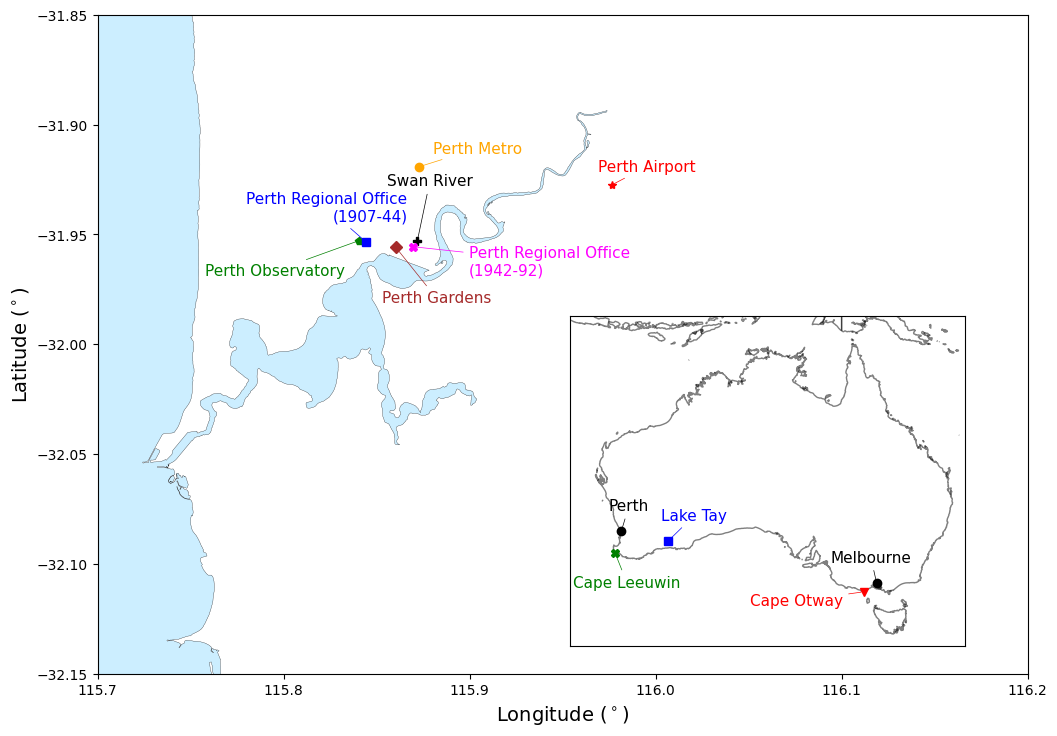

In [33]:
# --- Load your shapefiles ---
city_gdf = gpd.read_file(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\Shape Files\Perth Shape\GCCSA_2021_AUST_GDA2020.shp")
city_gdf = city_gdf.iloc[[16]]  # Just Greater Perth


borders_gdf = gpd.read_file(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\Shape Files\World Shape\ne_10m_admin_0_countries.shp")
borders_gdf.crs = 'EPSG:4326'

#Create the map before adding the location
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('white')  # Set figure bg to white
ax.set_facecolor('#cceeff')       # Ocean blue only inside plot

#Zoom in to the Perth area
ax.set_xlim(115.7, 116.2)
ax.set_ylim(-32.15, -31.85)

# Plot city boundary
city_gdf.plot(ax=ax, color='white', label='Greater Perth Region')
city_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.2)

# --- Plot Perth stations with non-overlapping labels ---
#Swan River
ax.plot(115.8719, -31.9531, color='black', marker='P', linestyle='none', markersize=6)
ax.annotate('Swan River',
            xy=(115.8719, -31.9531), xytext=(40, 40), textcoords='offset points',
            fontsize=11, color='black', ha='right',
            arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Perth Gardens
ax.plot(115.8603, -31.9558, color='brown', marker='D', linestyle='none', markersize=6)
ax.annotate('Perth Gardens',
            xy=(115.8603, -31.9558), xytext=(-10, -40), textcoords='offset points',
            fontsize=11, color='brown', ha='left',
            arrowprops=dict(arrowstyle='-', color='brown', lw=0.5))

# Perth Observatory
ax.plot(115.8406, -31.9528, color='green', marker='p', linestyle='none', markersize=6)
ax.annotate('Perth Observatory',
            xy=(115.8406, -31.9528), xytext=(-10, -25), textcoords='offset points',
            fontsize=11, color='green', ha='right',
            arrowprops=dict(arrowstyle='-', color='green', lw=0.5))

# Perth Regional Office Early
ax.plot(115.8442, -31.9533, color='blue', marker='s', linestyle='none', markersize=6)
ax.annotate('Perth Regional Office\n(1907-44)',
            xy=(115.8442, -31.9533), xytext=(30, 15), textcoords='offset points',
            fontsize=11, color='blue', ha='right',
            arrowprops=dict(arrowstyle='-', color='blue', lw=0.5))

# Perth Regional Office BoM
ax.plot(115.8697, -31.9556, color='magenta', marker='X', linestyle='none', markersize=6)
ax.annotate('Perth Regional Office\n(1942-92)',
            xy=(115.8697, -31.9556), xytext=(40, -20), textcoords='offset points',
            fontsize=11, color='magenta', ha='left',
            arrowprops=dict(arrowstyle='-', color='magenta', lw=0.5))

# Perth Metro BoM
ax.plot(115.8728, -31.9192, color='orange', marker='o', linestyle='none', markersize=6)
ax.annotate('Perth Metro',
            xy=(115.8728, -31.9192), xytext=(10, 10), textcoords='offset points',
            fontsize=11, color='orange', ha='left',
            arrowprops=dict(arrowstyle='-', color='orange', lw=0.5))

# Perth Airport BoM
ax.plot(115.9764, -31.9275, color='red', marker='*', linestyle='none', markersize=6)
ax.annotate('Perth Airport',
            xy=(115.9764, -31.9275), xytext=(-10, 10), textcoords='offset points',
            fontsize=11, color='red', ha='left',
            arrowprops=dict(arrowstyle='-', color='red', lw=0.5))

# Axis labels
ax.set_xlabel('Longitude ($^\circ$)', fontsize=14)
ax.set_ylabel('Latitude ($^\circ$)', fontsize=14)


#Now insert the map of Australia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', borderpad=2)
inset_ax.set_facecolor('white')  # Fix: Prevent ocean color from leaking through

borders_gdf.plot(ax=inset_ax, alpha=0.5, edgecolor='black', facecolor='none', linewidth=1)



# Perth
inset_ax.plot(115.8605, -31.9505, color='black', marker='o', linestyle='none', markersize=6)
inset_ax.annotate('Perth',
            xy=(115.8605, -31.9505), xytext=(20, 15), textcoords='offset points',
            fontsize=11, color='black', ha='right',
            arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

#Cape Leeuwin
inset_ax.plot(115.1348, -34.3712, color='green', marker='X', linestyle='none', markersize=6)
inset_ax.annotate('Cape Leeuwin',
            xy=(115.1348, -34.3712), xytext=(-30, -25), textcoords='offset points',
            fontsize=11, color='green', ha='left',
            arrowprops=dict(arrowstyle='-', color='green', lw=0.5))

#Cape Otway
inset_ax.plot(143.5234, -38.8345, color='red', marker='v', linestyle='none', markersize=6)
inset_ax.annotate('Cape Otway',
            xy=(143.5234, -38.8345), xytext=(-15, -10), textcoords='offset points',
            fontsize=11, color='red', ha='right',
            arrowprops=dict(arrowstyle='-', color='red', lw=0.5))

#Melbourne
inset_ax.plot(144.9631, -37.8136, color='black', marker='o', linestyle='none', markersize=6)
inset_ax.annotate('Melbourne',
            xy=(144.9631, -37.8136), xytext=(25, 15), textcoords='offset points',
            fontsize=11, color='black', ha='right',
            arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

#Lake Tay
inset_ax.plot(121.2226, -33.0325, color='blue', marker='s', linestyle='none', markersize=6)
inset_ax.annotate('Lake Tay',
            xy=(121.2226, -33.0325), xytext=(-5, 15), textcoords='offset points',
            fontsize=11, color='blue', ha='left',
            arrowprops=dict(arrowstyle='-', color='blue', lw=0.5))


inset_ax.set_xlim(110, 155)
inset_ax.set_ylim(-45, -7.5)
inset_ax.set_xlabel('', fontsize=8)
inset_ax.set_ylabel('', fontsize=8)
inset_ax.tick_params(axis='both', labelsize=7)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

#plt.tight_layout()

plt.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F1_Combined_Perth_Australia_Map.png",
            dpi=300, bbox_inches='tight')
plt.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F1_Combined_Perth_Australia_Map.png",
            dpi=300, bbox_inches='tight')

# 3. FIGURE 2 - A comparison between Corrected MSLP and Transcribed "As Read" JJA

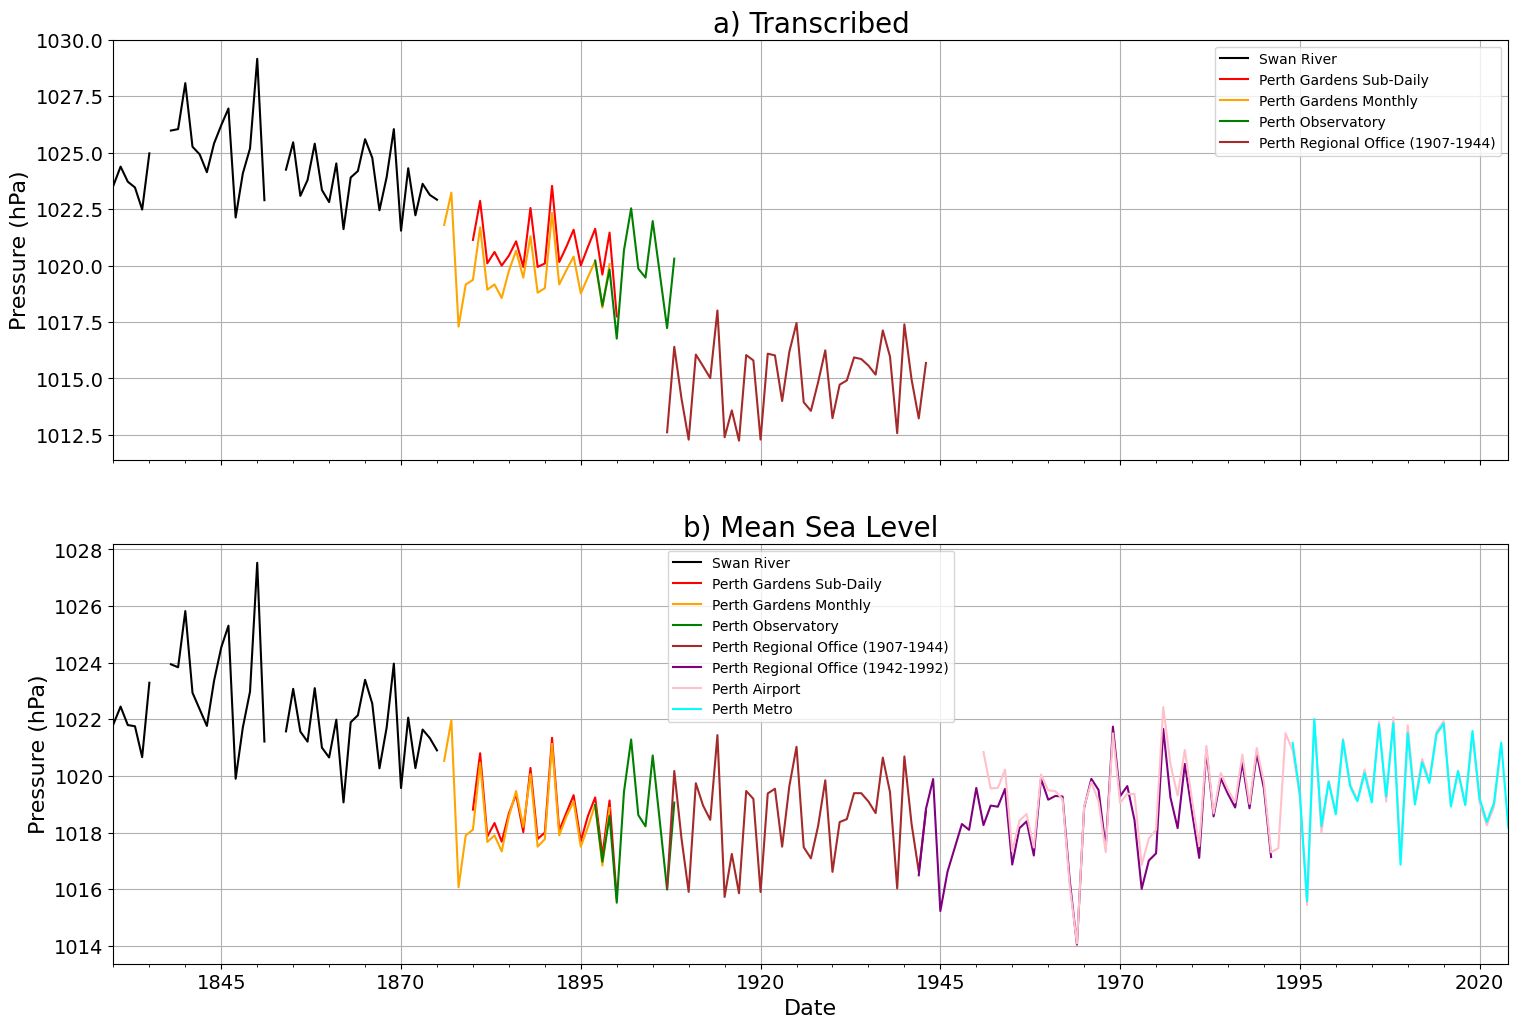

In [34]:
fig, ax = plt.subplots(2,1,figsize=(18, 12), sharex=True)  # Adjust the figsize as needed
ChatJR.filter_dataframe_by_months(SWR_PT[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[0],linestyle = '-',color= 'black')
ChatJR.filter_dataframe_by_months(SWR_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'black')
ChatJR.filter_dataframe_by_months(PG_PT[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[0],linestyle = '-',color= 'red')
ChatJR.filter_dataframe_by_months(PG_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'red')
ChatJR.filter_dataframe_by_months(PGm_PT[0], [6,7,8]).resample('YS').mean().plot(ax=ax[0],linestyle = '-',color= 'orange')
ChatJR.filter_dataframe_by_months(PGm_MSLP[0], [6,7,8]).resample('YS').mean().plot(ax=ax[1],color= 'orange')
ChatJR.filter_dataframe_by_months(PO_PT[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[0],linestyle = '-',color= 'green')
ChatJR.filter_dataframe_by_months(PO_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'green')
ChatJR.filter_dataframe_by_months(PRO_PT[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[0],linestyle = '-',color= 'brown')
ChatJR.filter_dataframe_by_months(PRO_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'brown')
ChatJR.filter_dataframe_by_months(PRO_MSLP_B[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'purple')
ChatJR.filter_dataframe_by_months(PA_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'pink')
ChatJR.filter_dataframe_by_months(PM_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean().plot(ax=ax[1],color= 'cyan')



ax[0].legend(['Swan River',
           'Perth Gardens Sub-Daily',
           'Perth Gardens Monthly',
           'Perth Observatory',
           'Perth Regional Office (1907-1944)'])


ax[1].legend(['Swan River',
           'Perth Gardens Sub-Daily',
           'Perth Gardens Monthly',
           'Perth Observatory',
           'Perth Regional Office (1907-1944)',
           'Perth Regional Office (1942-1992)',
           'Perth Airport',
           'Perth Metro'])

ax[1].set_xlabel('Date',fontsize = 16)
ax[1].set_ylabel('Pressure (hPa)',fontsize = 16)
ax[0].set_ylabel('Pressure (hPa)',fontsize = 16)
ax[0].set_title('a) Transcribed',fontsize = 20)
ax[1].set_title('b) Mean Sea Level',fontsize = 20)

# Adjust tick label sizes
ax[0].tick_params(axis='both', labelsize=14)  # For x-axis tick labels
ax[1].tick_params(axis='both', labelsize=14)  # For x-axis tick labels

ax[0].grid()
ax[1].grid()

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F2_JJA_Pressure_Comparisons.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F2_JJA_Pressure_Comparisons.png", dpi=300, bbox_inches='tight')


# 4. FIGURE 3 - Winter (JJA) using the final Perth record 9am and 3pm data

In [35]:
P_MSLP

[                       MSLP
 Date                       
 1830-05-22 15:00:00  1009.9
 1830-05-24 09:00:00  1002.8
 1830-05-24 15:00:00  1006.5
 1830-05-25 09:00:00  1014.0
 1830-05-25 15:00:00  1013.7
 ...                     ...
 2024-12-29 15:00:00  1008.8
 2024-12-30 09:00:00  1016.7
 2024-12-30 15:00:00  1013.6
 2024-12-31 09:00:00  1015.8
 2024-12-31 15:00:00  1011.5
 
 [131297 rows x 1 columns],
               MSLP
 Date              
 1830-05-22  1009.9
 1830-05-23     NaN
 1830-05-24  1004.6
 1830-05-25  1013.8
 1830-05-26  1017.2
 ...            ...
 2024-12-27  1021.8
 2024-12-28  1017.4
 2024-12-29  1010.3
 2024-12-30  1015.2
 2024-12-31  1013.6
 
 [71082 rows x 1 columns],
               MSLP
 Date              
 1830-06-01  1021.5
 1830-07-01  1015.8
 1830-08-01  1016.5
 1830-09-01  1020.5
 1830-10-01  1016.2
 ...            ...
 2024-08-01  1016.3
 2024-09-01  1021.1
 2024-10-01  1016.6
 2024-11-01  1014.9
 2024-12-01  1011.6
 
 [2335 rows x 1 columns],
               M

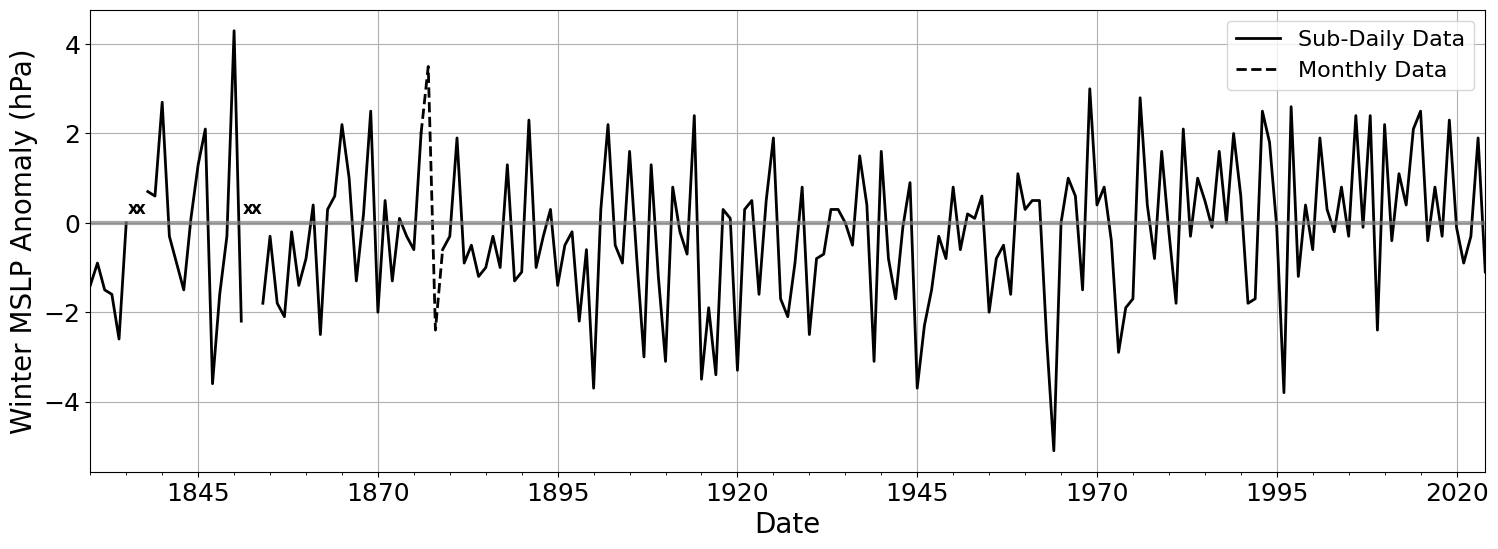

In [36]:
##a ALL FIGURES ARE WITH SD TO DAILY THEN Y, ONLY M IS INVOLVED WHEN WE CANNOT FILL IT
fig, ax = plt.subplots(figsize=(18, 6))  # Adjust the figsize as needed
#Get the winter period
P_MSLP_M_Winter = ChatJR.filter_dataframe_by_months(P_MSLP[1], [6,7,8]).resample('YS').mean() #daily average by 9am and 3pm
P_MSLP_M_Winter_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
P_MSLP_M_Winter = P_MSLP_M_Winter.combine_first(P_MSLP_M_Winter_76_79).round(1) #Ensuring we have the 1876-1879 period

#Calculate the winter anom
P_MSLP_M_Winter_Anom = P_MSLP_M_Winter[['MSLP']].round(1) - P_MSLP_M_Winter['MSLP'].loc['1961':'1990'].mean().round(1)

#Plot the data and labelling 
P_MSLP_M_Winter_Anom['MSLP'].loc[:'1876'].plot(ax=ax,linestyle = '-',color= 'black',linewidth = 2)
P_MSLP_M_Winter_Anom['MSLP'].loc['1876':'1879'].plot(ax=ax,linestyle = '--',color= 'black',linewidth = 2)
P_MSLP_M_Winter_Anom['MSLP'].loc['1879':].plot(ax=ax,linestyle = '-',color= 'black',linewidth = 2)

ax.legend(['Sub-Daily Data',
           'Monthly Data'],fontsize = 16)
#ax.set_title('Pressure Averages During Winter (JJA)',fontsize = 26)
ax.set_xlabel('Date',fontsize = 20)
ax.set_ylabel('Winter MSLP Anomaly (hPa)',fontsize = 20)
# Adjust tick label sizes
ax.tick_params(axis='both', labelsize=18)  # For x-axis tick labels

# Mark missing MSLP values with a bold 'x'
for idx, row in P_MSLP_M_Winter_Anom.iterrows():
    if pd.isna(row['MSLP']):
        ax.text(idx, 0.55, 'x',  # now exactly at y=0
                ha='center', va='bottom', color='black',
                fontsize=12, fontweight='bold',
                transform=ax.get_xaxis_transform())

ax.axhline(y=0, color='grey', linestyle='-', linewidth=3, alpha=0.7)

ax.grid()
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F3_JJA_MSLP_FULL_RECORD_9am_3pm_only.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F3_JJA_MSLP_FULL_RECORD_9am_3pm_only.png", dpi=300, bbox_inches='tight')


# 5. Correlation Comparison for Inside the Manuscript

## 5.1 '''Perth MSLP and Raindays'''


In [37]:
months_to_extract = [6,7,8]
'''Winter Perth MSLP and Raindays'''
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(1)

Col2 = ChatJR.filter_dataframe_by_months(P_RD[0], months_to_extract).resample('YS').sum().round(0)
Col22 = ChatJR.filter_dataframe_by_months(P_RD[1].loc['1876':'1879'], [6,7,8]).resample('YS').sum()
Col2 = Col2.combine_first(Col22).round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean())
Col2 = Col2.apply(pd.to_numeric, errors='coerce').round(0) 

combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_MSLP_and_Raindays = ChatJR.corr_sig(combined['MSLP'],combined['RAINDAYS'])


## 5.2 '''Perth MSLP and Rainfall'''

In [38]:
months_to_extract = [6,7,8]
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = ChatJR.filter_dataframe_by_months(P_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = Col2 - Col2.loc['1961':'1990'].mean()

combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1)
Perth_MSLP_and_Rainfall =  ChatJR.corr_sig(combined['MSLP'].loc['1880':],combined['RAINFALL'].loc['1880':])


## 5.3 '''PERTH RAINDAYS AND RAINFALL'''

In [39]:
months_to_extract = [6,7,8]
Col1 = ChatJR.filter_dataframe_by_months(P_RD[0], months_to_extract).resample('YS').sum().round(0)
Col12 = ChatJR.filter_dataframe_by_months(P_RD[1].loc['1876':'1879'], [6,7,8]).resample('YS').sum()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(0)
Col1 = Col1.apply(pd.to_numeric, errors='coerce').round(0) 

Col2 = ChatJR.filter_dataframe_by_months(P_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)

combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_Raindays_and_Rainfall =  ChatJR.corr_sig(combined['RAINDAYS'].loc['1880':],combined['RAINFALL'].loc['1880':])

## 5.4 '''Perth MSLP and Cape Leeuwin'''

In [40]:
months_to_extract = [6,7,8]
'''Perth MSLP and Cape Leeuwin'''
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = ChatJR.filter_dataframe_by_months(CL_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col2 = Col2 - Col2.loc['1961':'1990'].mean()
Col2 = Col2.rename(columns={'MSLP': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1)
Perth_MSLP_and_CL =  ChatJR.corr_sig(combined['MSLP'],combined['CL'])


###################


'''Perth MSLP and Cape Leeuwin 1907-1944'''
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = ChatJR.filter_dataframe_by_months(CL_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col2 = Col2 - Col2.loc['1961':'1990'].mean()
Col2 = Col2.rename(columns={'MSLP': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().loc['1907':'1944-04'].round(1)
Perth_MSLP_and_CL_07_43 =  ChatJR.corr_sig(combined['MSLP'],combined['CL'])


## 5.5 '''Perth MSLP and Cape Otway'''


In [41]:
months_to_extract = [6,7,8]
'''Perth MSLP and Cape Otway'''
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = ChatJR.filter_dataframe_by_months(CO_MSLP[0], months_to_extract).resample('YS').mean().round(1)
Col2 = Col2 - Col2.loc['1961':'1990'].mean()


Col2 = Col2.rename(columns={'MSLP': 'CO'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1)
Perth_MSLP_and_CO = ChatJR.corr_sig(combined['MSLP'],combined['CO'])

###############################


'''Perth MSLP and Cape Otway 1907-1943'''
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = ChatJR.filter_dataframe_by_months(CO_MSLP[0], months_to_extract).resample('YS').mean().round(1)
Col2 = Col2 - Col2.loc['1961':'1990'].mean()
Col2 = Col2.rename(columns={'MSLP': 'CO'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().loc['1907':'1944-04'].round(1)
Perth_MSLP_and_CO_07_43 = ChatJR.corr_sig(combined['MSLP'],combined['CO'])

## 5.6 '''Perth MSLP and Lake Tay Rainfall'''


In [42]:
months_to_extract = [3,4,5,6,7,8,9]
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col1.loc[Col1.index.year == 1836, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1837, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1852, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1853, 'MSLP'] = np.nan
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], months_to_extract).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = LT_RF
Col2 = Col2 - Col2.loc['1961':'1990'].mean()

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1)
Perth_MSLP_and_LAKE_TAY =  ChatJR.corr_sig(combined['MSLP'],combined['Mar_Sept_Rainfall'])


## 5.7 '''Perth Raindays and Lake Tay Rainfall'''

In [43]:
months_to_extract = [3,4,5,6,7,8,9]
'''Perth Raindays and Lake Tay Rainfall'''
Col1 = ChatJR.filter_dataframe_by_months(P_RF[0], months_to_extract).resample('YS').sum().round(1)
Col1.loc[Col1.index.year == 1836, 'RAINFALL'] = np.nan
Col1.loc[Col1.index.year == 1837, 'RAINFALL'] = np.nan
Col1.loc[Col1.index.year == 1852, 'RAINFALL'] = np.nan
Col1.loc[Col1.index.year == 1853, 'RAINFALL'] = np.nan
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = LT_RF
Col2 = Col2 - Col2.loc['1961':'1990'].mean()

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1)
Perth_RF_and_LAKE_TAY =  ChatJR.corr_sig(combined['RAINFALL'].loc['1880':],combined['Mar_Sept_Rainfall'].loc['1880':])

## 5.8 '''Perth Raindays and Lake Tay Rain Days'''

In [44]:
months_to_extract = [3,4,5,6,7,8,9]
Col1 = ChatJR.filter_dataframe_by_months(P_RD[0], months_to_extract).resample('YS').sum().round(0)
Col1.loc[Col1.index.year == 1836, 'RAINDAYS'] = np.nan
Col1.loc[Col1.index.year == 1837, 'RAINDAYS'] = np.nan
Col1.loc[Col1.index.year == 1852, 'RAINDAYS'] = np.nan
Col1.loc[Col1.index.year == 1853, 'RAINDAYS'] = np.nan
Col12 = ChatJR.filter_dataframe_by_months(P_RD[1].loc['1876':'1879'], months_to_extract).resample('YS').sum()
Col1 = Col1.combine_first(Col12)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(0)
Col1 = Col1.apply(pd.to_numeric, errors='coerce').round(0)  # if DataFrame

Col2 = LT_RF
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_RD_and_LAKE_TAY =  ChatJR.corr_sig(combined['RAINDAYS'],combined['Mar_Sept_Rainfall'])


## 5.9 '''Perth MSLP and Salmon Lake Rainfall'''


In [45]:
months_to_extract = [3,4,5,6,7,8,9]
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], months_to_extract).resample('YS').mean()
Col1 = Col1.combine_first(Col12)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(1)
Col1 = Col1.apply(pd.to_numeric, errors='coerce').round(1)  # if DataFrame

Col2 = ChatJR.filter_dataframe_by_months(SG_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_MSLP_and_SALMON_GUMS_RF =  ChatJR.corr_sig(combined['MSLP'],combined['Rainfall'])


In [46]:
months_to_extract = [6,7,8]
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], months_to_extract).resample('YS').mean()
Col1 = Col1.combine_first(Col12)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(1)
Col1 = Col1.apply(pd.to_numeric, errors='coerce').round(1)  # if DataFrame

Col2 = ChatJR.filter_dataframe_by_months(SG_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_MSLP_and_SALMON_GUMS_RF_Wint =  ChatJR.corr_sig(combined['MSLP'],combined['Rainfall'])


In [47]:
months_to_extract = [3,4,5,6,7,8,9]
Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('D').mean().resample('YS').mean().round(1)
Col1.loc[Col1.index.year == 1836, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1837, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1852, 'MSLP'] = np.nan
Col1.loc[Col1.index.year == 1853, 'MSLP'] = np.nan
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], months_to_extract).resample('YS').mean()
Col1 = Col1.combine_first(Col12).round(1)
Col1 = Col1 - Col1.loc['1961':'1990'].mean()

Col2 = LT_RF
Col2 = Col2 - Col2.loc['1961':'1990'].mean()

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().round(1).loc['1932-01-01':]
Perth_MSLP_and_LAKE_TAY_32_05 =  ChatJR.corr_sig(combined['MSLP'],combined['Mar_Sept_Rainfall'])
combined

Col1 = ChatJR.filter_dataframe_by_months(P_MSLP[0], months_to_extract).resample('YS').mean().round(1)
Col12 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], months_to_extract).resample('YS').mean()
Col1 = Col1.combine_first(Col12)
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(1)
Col1 = Col1.apply(pd.to_numeric, errors='coerce').round(1)  # if DataFrame

Col2 = ChatJR.filter_dataframe_by_months(SG_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)

#Col2 = Col2.rename(columns={'Raindays': 'CL'})
combined = pd.concat([Col1,Col2],axis = 1).dropna().loc[:'2005-01-01']
Perth_MSLP_and_SALMON_GUMS_RF_32_05 =  ChatJR.corr_sig(combined['MSLP'],combined['Rainfall'])


## 5.10 '''Lake Tay Rainfall and Salmon Lake Rainfall'''


In [48]:
months_to_extract = [3,4,5,6,7,8,9]
Col1 = LT_RF
Col1 = (Col1 - Col1.loc['1961':'1990'].mean()).round(1)
Col1 = Col1.rename(columns={'Mar_Sept_Rainfall': 'LT'})

Col2 = ChatJR.filter_dataframe_by_months(SG_RF[0], months_to_extract).resample('YS').sum().round(1)
Col2 = (Col2 - Col2.loc['1961':'1990'].mean()).round(1)
Col2 = Col2.rename(columns={'Rainfall': 'SG'})
combined = pd.concat([Col1,Col2],axis = 1).dropna()
Lake_Tay_and_SALMON_GUMS_RF_Wint =  ChatJR.corr_sig(combined['LT'],combined['SG'])


## 5.11 ADD TO EXCEL

In [49]:
Corr_Data = pd.DataFrame(Perth_MSLP_and_Raindays)
Corr_Data.columns = ['Winter Perth MSLP / Winter Perth Rain Days']

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_Rainfall)
Corr_Data_New.columns = ['Winter Perth MSLP / Winter Perth Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_Raindays_and_Rainfall)
Corr_Data_New.columns = ['Winter Perth Rain Days / Winter Perth Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)


Corr_Data_New = pd.DataFrame(Perth_MSLP_and_CL)
Corr_Data_New.columns = ['Winter Perth MSLP / Winter Cape Leeuwin MSLP']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_CL_07_43)
Corr_Data_New.columns = ['Winter Perth MSLP / Winter Cape Leeuwin MSLP (1907-44)']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_CO)
Corr_Data_New.columns = ['Winter Perth MSLP / Winter Cape Otway MSLP']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_CO_07_43)
Corr_Data_New.columns = ['Winter Perth MSLP / Winter Cape Otway (1907-44) MSLP']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_LAKE_TAY)
Corr_Data_New.columns = ['Mar-Sept Perth MSLP / Lake Tay Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_RF_and_LAKE_TAY)
Corr_Data_New.columns = ['Mar-Sept Winter Perth Rainfall / Lake Tay Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_RD_and_LAKE_TAY)
Corr_Data_New.columns = ['Mar-Sept Perth Rain Days / Lake Tay Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_SALMON_GUMS_RF)
Corr_Data_New.columns = ['Mar-Sept Perth MSLP /Mar-Sept Salmon Gums Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_SALMON_GUMS_RF_Wint)
Corr_Data_New.columns = ['Winter Perth MSLP /Winter Salmon Gums Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Lake_Tay_and_SALMON_GUMS_RF_Wint)
Corr_Data_New.columns = ['Mar-Sept Lake Tay Rainfall /Mar-Sept Salmon Gums Rainfall']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_LAKE_TAY_32_05)
Corr_Data_New.columns = ['Mar-Sept Perth MSLP / Lake Tay Rainfall (1932->2005)']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data_New = pd.DataFrame(Perth_MSLP_and_SALMON_GUMS_RF_32_05)
Corr_Data_New.columns = ['Mar-Sept Perth MSLP / Salmon Gums Rainfall (1932->2005)']
Corr_Data = pd.concat([Corr_Data,Corr_Data_New], axis = 1)

Corr_Data.to_csv(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Manuscript files\Correlation_Summary.csv")
Corr_Data

,Winter Perth MSLP / Winter Perth Rain Days,Winter Perth MSLP / Winter Perth Rainfall,Winter Perth Rain Days / Winter Perth Rainfall,Winter Perth MSLP / Winter Cape Leeuwin MSLP,Winter Perth MSLP / Winter Cape Leeuwin MSLP (1907-44),Winter Perth MSLP / Winter Cape Otway MSLP,Winter Perth MSLP / Winter Cape Otway (1907-44) MSLP,Mar-Sept Perth MSLP / Lake Tay Rainfall,Mar-Sept Winter Perth Rainfall / Lake Tay Rainfall,Mar-Sept Perth Rain Days / Lake Tay Rainfall,Mar-Sept Perth MSLP /Mar-Sept Salmon Gums Rainfall,Winter Perth MSLP /Winter Salmon Gums Rainfall,Mar-Sept Lake Tay Rainfall /Mar-Sept Salmon Gums Rainfall,Mar-Sept Perth MSLP / Lake Tay Rainfall (1932->2005),Mar-Sept Perth MSLP / Salmon Gums Rainfall (1932->2005)
Correlation,-0.68,-0.72,0.72,0.93,0.96,0.66,0.74,-0.25,0.18,0.2,-0.38,-0.41,0.61,-0.2,-0.41
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.01,0.0,0.0,0.0,0.09,0.0
Significance,99%,99%,99%,99%,99%,99%,99%,99%,95%,99%,99%,99%,99%,,99%


# 6. FIGURE 5 - RAIN DAYS COMPARISON

In [50]:
#Get the rain days in a monthly state AND A WINTER STATE
P_RD_WINTER = ChatJR.filter_dataframe_by_months(P_RD[0], [6,7,8]).resample('YS').sum()


#Calculate the anomaly and remove 1836, 1837, 1852 and 1853  
P_RD_WINTER_Anom = P_RD_WINTER[['RAINDAYS']].round(1) - P_RD_WINTER['RAINDAYS'].loc['1961':'1990'].mean().round(1)
P_RD_WINTER_Anom.loc[P_RD_WINTER_Anom.index.isin(['1836-01-01','1837-01-01','1852-01-01','1853-01-01']), 'RAINDAYS'] = np.nan


#Get the overall correlation
Col1 = P_RD_WINTER_Anom
Col2 = P_MSLP_M_Winter_Anom
combined = pd.concat([Col1,Col2],axis = 1).dropna()
Perth_MSLP_and_Raindays_Winter = ChatJR.corr_sig(combined['MSLP'],combined['RAINDAYS']) #so NaNs do not impact the overall correlation
combined = pd.concat([Col1,Col2],axis = 1)#make sure we keep all the values so we can run the correlaiton

P_MSLP_M_Winter_Anom['Year'] = P_MSLP_M_Winter_Anom.index.year
P_RD_WINTER_Anom['Year'] = P_RD_WINTER_Anom.index.year


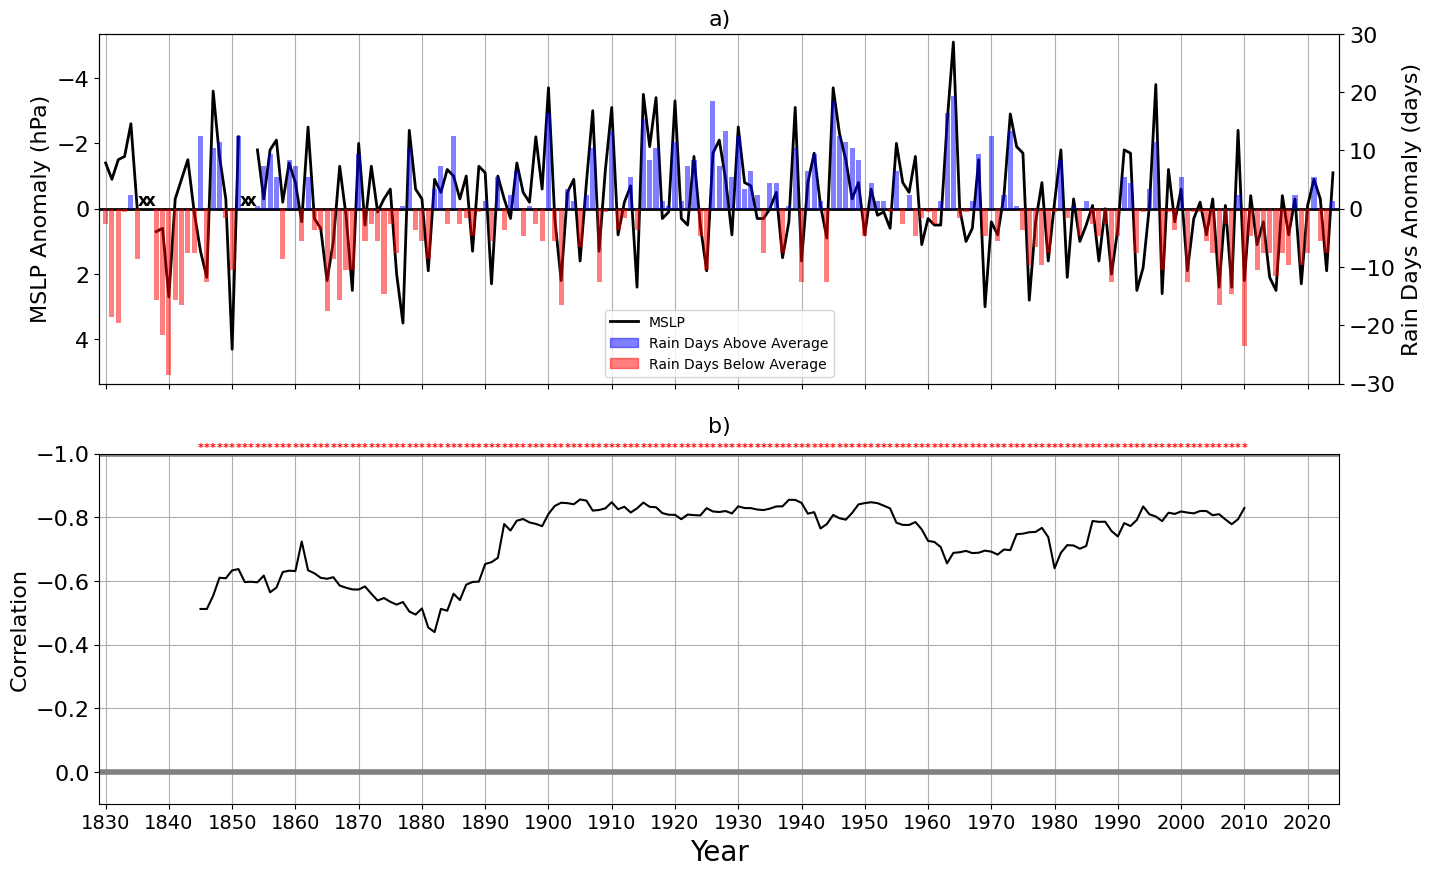

In [51]:
import matplotlib.patches as mpatches

# We want to create two subplots, 
#the top plot overlays the -1 MSLP with Rain Days
#The bottom plot overlays the -1 correlation relationshio bascially
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Common x-range across both series
x_min = min(P_MSLP_M_Winter_Anom['Year'].min(), P_RD_WINTER_Anom['Year'].min())
x_max = max(P_MSLP_M_Winter_Anom['Year'].max(), P_RD_WINTER_Anom['Year'].max())

#twinax, with MSLP flipped
ax1.plot(P_MSLP_M_Winter_Anom['Year'].loc[:'2024'], P_MSLP_M_Winter_Anom['MSLP'].loc[:'2024'], linestyle='-', color='black', label='MSLP',linewidth = 2)
ax1.set_ylabel('MSLP Anomaly (hPa)', color='black', fontsize=16)
ax1.tick_params('y', colors='black', labelsize=16)
ax1.grid(True, axis='x', which='major')       # vertical majors only
ax1.set_xlim(x_min, x_max)
ax1.invert_yaxis()

# Mark NaNs for MSLP
#nan_locs_mslp = P_MSLP_M_Winter_Anom[P_MSLP_M_Winter_Anom['MSLP'].isna()]['Year']
#for x in nan_locs_mslp:
#    ax1.text(x, 0.2, 'x', color='black', fontsize=10, ha='center', va='center', fontweight='bold')

    
# Right axis: Rain Days (twin)
ax1_r = ax1.twinx()
ax1_r.axhline(y=0, color='black', linestyle='-', linewidth=0)  # invisible baseline on right axis
colors = ['blue' if val > 0 else 'red' for val in P_RD_WINTER_Anom['RAINDAYS'].loc[:'2024']]
ax1_r.bar(P_RD_WINTER_Anom['Year'].loc[:'2024'], P_RD_WINTER_Anom['RAINDAYS'].loc[:'2024'], color=colors, alpha=0.5,  width=0.8,  label='Rain days')
#ax1_r.bar(P_RD_WINTER_Anom['Year'].loc[:'2024'], P_RD_WINTER_Anom['RAINDAYS'].loc[:'2024'],color='#333333', alpha=0.5, width=0.8, label='Rain days')
ax1_r.set_ylabel('Rain Days Anomaly (days)', color='black', fontsize=16)
ax1_r.tick_params('y', colors='black', labelsize=16)
blue_patch = mpatches.Patch(color='blue', label='Rain Days Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rain Days Below Average', alpha=0.5)


# Mark NaNs for Rain Days
nan_locs_rd = P_RD_WINTER_Anom[P_RD_WINTER_Anom['RAINDAYS'].isna()]['Year']
for x in nan_locs_rd:
    ax1_r.text(x, 1.5, 'x', color='black', fontsize=12, ha='center', va='center', fontweight='bold')

# Get existing legend handles/labels from both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax1_r.get_legend_handles_labels()

# Combine all legend items, including the custom color patches
all_handles = h1 + [blue_patch, red_patch]
all_labels = l1 + ['Rain Days Above Average', 'Rain Days Below Average']

# Show the combined legend
ax1.legend(all_handles, all_labels, loc='lower center', frameon=True)

# Hide x labels on the top panel so only the bottom panel shows them
ax1.set_xticklabels([])

# Make both y-axes symmetric about zero so 0 aligns (visually centered)
mslp_abs = np.nanmax(np.abs(P_MSLP_M_Winter_Anom['MSLP'].to_numpy()))
rd_abs   = np.nanmax(np.abs(P_RD_WINTER_Anom['RAINDAYS'].to_numpy()))
pad = 1.05  # a touch of headroom

# Left axis is inverted, keep it symmetric around 0 (top then bottom)
ax1.set_ylim(mslp_abs*pad, -mslp_abs*pad)

# Right axis (Rain Days) symmetric around 0
ax1_r.set_ylim(-rd_abs*pad, rd_abs*pad)

# Draw the zero line once; with symmetric limits the right-axis 0 coincides
ax1.axhline(y=0, color='k', linestyle='-', linewidth=2, zorder=4)
ax1.set_xlim(1829, 2025)


Corr_Plot = ChatJR.running_correlation_with_p(combined, 'MSLP', 'RAINDAYS', 31)

# Now get the 31-year correlation
Corr_Plot = ChatJR.running_correlation_with_p(combined, 'MSLP', 'RAINDAYS', 31)
Corr_Plot['Year'] = Corr_Plot.index.year

# Plot the running correlation
ax3.plot(Corr_Plot['Year'], Corr_Plot['correlation'], color='black', label="Pearson's r Correlation")


# Axis and grid setup
ax3.set_ylabel('Correlation', color='k', fontsize=16)
ax3.tick_params('y', colors='k', labelsize=16)
ax3.grid(True)
ax3.axhline(y=0, color='grey', linestyle='-', linewidth=4)
ax3.axhline(y=-1, color='grey', linestyle='-', linewidth=4)
ax3.axhline(y=1, color='grey', linestyle='-', linewidth=4)
ax3.tick_params('x', colors='k', labelsize=16)

# Set y/x limits and invert as before
ax3.set_ylim(-1, 0.1)
ax3.set_xlim(1829, 2025)
ax3.invert_yaxis()

# Make sure ax3 shows its x labels
ax3.tick_params(axis='x', labelbottom=True)

# Optional: nicer year ticks
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
ax3.xaxis.set_major_locator(MultipleLocator(10))  # every 10 years
#ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # integers
ax3.set_xlabel('Year', fontsize=20)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='x', labelrotation=0)
ax1.set_title('a)',fontsize = 16)
ax3.set_title('b)', fontsize=16, pad=15)


# Get y-limits after plotting
ymin, ymax = ax3.get_ylim()

# Since the axis is inverted, the "top" is ymin
y_top = ymax

# Small offset to move markers slightly below the frame
offset = (ymin - ymax) * -0.005   # 2% of the axis range

for idx, row in Corr_Plot.iterrows():
    if row['significant'] == '90%':
        ax3.text(row['Year'], y_top + offset, '+',
                 ha='center', va='bottom',
                 color='red', fontsize=8, fontweight='bold')
    elif row['significant'] in ('95%', '99%'):
        ax3.text(row['Year'], y_top + offset, '*',
                 ha='center', va='bottom',
                 color='red', fontsize=8, fontweight='bold')


# Save outputs (same paths)
# =========================
fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F5_JJA_Pressure_RAINDAYS_Comparisons_Inverted_31yr.png",
            dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F5_JJA_Pressure_RAINDAYS_Comparisons_Inverted_31yr.png",
            dpi=300, bbox_inches='tight')

P_RD_WINTER_Anom.round(1).to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_RAINDAYS_ANOMALIES_WINTER_1830-2024.csv")

# 7. FIGURE 6. Lake Tay against Pressure and Raindays

In [52]:
#Remove periods that have less then 5/7 of data avaliable
P_Ext_Winter_MSLP = ChatJR.filter_dataframe_by_months(P_MSLP[0], [3, 4, 5, 6, 7, 8, 9])
P= P_Ext_Winter_MSLP.resample('D').mean().resample('YS').count()
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.resample('YS').mean().round(1)
P_Ext_Winter_MSLP[P['MSLP'] < 153] = np.nan #TWO MONTHS OF MISSING DATA
P_Ext_Winter_MSLP.loc['1830'] = np.nan
#Remove raindays that are associacted with nans in mslp
P_Ext_Winter_RD = ChatJR.filter_dataframe_by_months(P_RD[0], [3, 4, 5, 6, 7, 8, 9])
P = P_Ext_Winter_RD.resample('YS').count()
P_Ext_Winter_RD = P_Ext_Winter_RD.resample('YS').sum().round(0)
P_Ext_Winter_RD[P['RAINDAYS'] < 153] = np.nan #TWO MONTHS OF MISSING DATA
P_Ext_Winter_RD = P_Ext_Winter_RD.loc[:'2024']
P_Ext_Winter_RD.loc['1830'] = np.nan

#Rainfall
P_Ext_Winter_RF = ChatJR.filter_dataframe_by_months(P_RF[0], [3, 4, 5, 6, 7, 8, 9])
P = P_Ext_Winter_RF.resample('YS').count()
P_Ext_Winter_RF = P_Ext_Winter_RF.resample('YS').sum().round(1)
P_Ext_Winter_RF[P.loc['1880':]['RAINFALL'] < 153] = np.nan
P_Ext_Winter_RF = P_Ext_Winter_RF.loc[:'2024'].loc['1880':'2024']


#Add the raindays for 76-79 and mslp
P_Ext_Winter_RD_76_79 = ChatJR.filter_dataframe_by_months(P_RD[1].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').sum().round(0)
P_Ext_Winter_MSLP_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').mean().round(0)
#Combime
P_Ext_Winter_RD = P_Ext_Winter_RD.combine_first(P_Ext_Winter_RD_76_79).round(1)
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.combine_first(P_Ext_Winter_MSLP_76_79).round(1)

#Anomalies
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP[['MSLP']].round(1) - P_Ext_Winter_MSLP['MSLP'].loc['1961':'1990'].mean().round(1)
P_Ext_Winter_RD = P_Ext_Winter_RD[['RAINDAYS']].round(0) - P_Ext_Winter_RD['RAINDAYS'].loc['1961':'1990'].mean().round(0)
P_Ext_Winter_RF = P_Ext_Winter_RF[['RAINFALL']].round(1) - P_Ext_Winter_RF['RAINFALL'].loc['1961':'1990'].mean().round(1)
LT_RF_ANOM = LT_RF[['Mar_Sept_Rainfall']].round(1) - LT_RF['Mar_Sept_Rainfall'].loc['1961':'1990'].mean().round(1)

#save RD Anomalies
P_Ext_Winter_RD.to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_RAINDAYS_ANOMALIES_Extended_Winter_1830-2024.csv")

#Combine Lake Tay Rainfall with Raindays and Rainfall
combined = pd.concat([LT_RF_ANOM, P_Ext_Winter_MSLP,P_Ext_Winter_RD,P_Ext_Winter_RF], axis=1)
combined['Year'] = combined.index.year
combined

,Mar_Sept_Rainfall,MSLP,RAINDAYS,RAINFALL,Year
Date,,,,,
1830-01-01,-53.2,NaN,NaN,NaN,1830
1831-01-01,-2.2,-1.0,-39.0,NaN,1831
1832-01-01,-8.2,-3.0,-30.0,NaN,1832
1833-01-01,-65.2,-0.3,-3.0,NaN,1833
1834-01-01,-4.2,-1.1,-6.0,NaN,1834
...,...,...,...,...,...
2020-01-01,NaN,-0.2,-8.0,-182.0,2020
2021-01-01,NaN,-0.6,6.0,-30.2,2021
2022-01-01,NaN,-0.9,-8.0,-71.2,2022


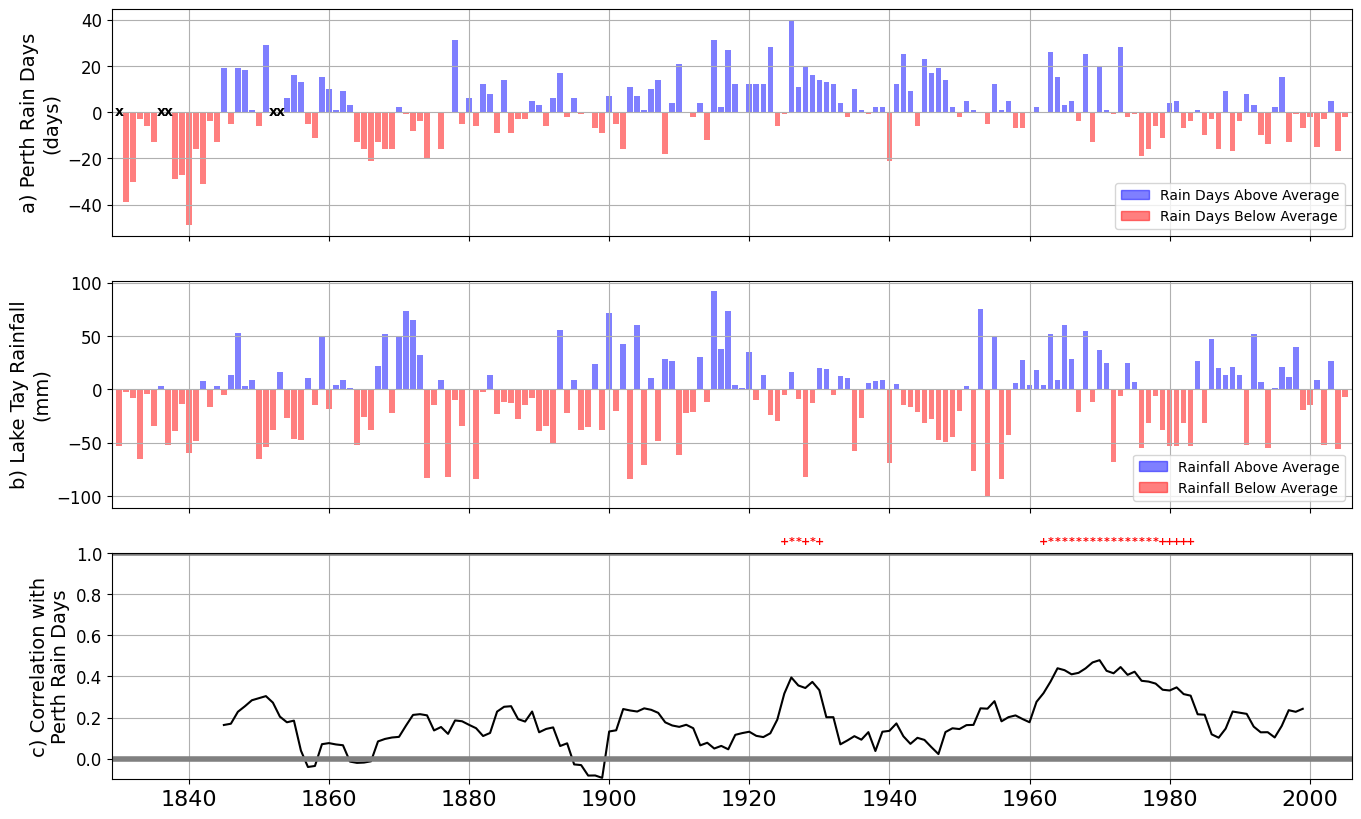

In [53]:

#Now lets plot the figures
fig,axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
ax = axes[0]
#Plot 1 tells us the fluctuations
#Get the red and blue color plot
colors = ['blue' if val > 0 else 'red' for val in combined['RAINDAYS'].loc[:'2005']]
#Add the bar plot with the color scheme
ax.bar(combined['Year'].loc[:'2005'], combined['RAINDAYS'].loc[:'2005'], color=colors, alpha=0.5, width=0.8)
#Set the x bounds
ax.set_xlim(1829, 2006)
#Set the labels and parameters
ax.set_ylabel('Perth Rain Days (days)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#For the legend
blue_patch = mpatches.Patch(color='blue', label='Rain Days Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rain Days Below Average', alpha=0.5)
# Combine all legend items, including the custom color patches
all_handles = [blue_patch, red_patch]
all_labels = ['Rain Days Above Average', 'Rain Days Below Average']
# Show the combined legend
ax.legend(all_handles, all_labels, loc='lower right', frameon=True,fontsize = 10)

#Now repeat for the next one



ax = axes[1]
#Plot 1 tells us the fluctuations
#Get the red and blue color plot
colors = ['blue' if val > 0 else 'red' for val in combined['Mar_Sept_Rainfall'].loc[:'2005']]
#Add the bar plot with the color scheme
ax.bar(combined['Year'], combined['Mar_Sept_Rainfall'], color=colors, alpha=0.5, width=0.8)
#Set the x bounds
ax.set_xlim(1829, 2006)
#Set the labels and parameters
ax.set_ylabel('Lake Tay Rainfall (mm)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#For the legend
blue_patch = mpatches.Patch(color='blue', label='Rainfall Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rainfall Below Average', alpha=0.5)
# Combine all legend items, including the custom color patches
all_handles = [blue_patch, red_patch]
all_labels = ['Rainfall Above Average', 'Rainfall Below Average']
# Show the combined legend
ax.legend(all_handles, all_labels, loc='lower right', frameon=True,fontsize = 10)









LT_P_RD = ChatJR.running_correlation_with_p(combined, 'Mar_Sept_Rainfall', 'RAINDAYS',31)



LT_P_RD['Year'] = LT_P_RD.index.year
ax = axes[2]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_RD['Year'], LT_P_RD['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1829, 2006)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='grey', linestyle='-', linewidth=4)
ax.axhline(y = 1, color='grey', linestyle='-', linewidth=4)
ax.set_ylim(-0.1,1)

X = 1.08
for idx, row in LT_P_RD.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

axes[0].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[1].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[2].tick_params(axis='y', labelcolor='black', labelsize=12)

axes[0].set_ylabel('a) Perth Rain Days\n(days)', color='black', fontsize=14)
axes[1].set_ylabel('b) Lake Tay Rainfall\n(mm)', color='black', fontsize=14)
axes[2].set_ylabel('c) Correlation with\nPerth Rain Days', color='black', fontsize=14)

nan_locs = combined[combined['RAINDAYS'].isna()]['Year']
for x in nan_locs:
    axes[0].text(x, 0.3, 'x', color='black', fontsize=10, ha='center', va='center', fontweight='bold')
nan_locs = combined[combined['Mar_Sept_Rainfall'].isna()]['Year']

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F6_Perth_Lake_Tay_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F6_Perth_Lake_Tay_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')



# 8. Supplement 3 - Lake Tay Perth MSLP 

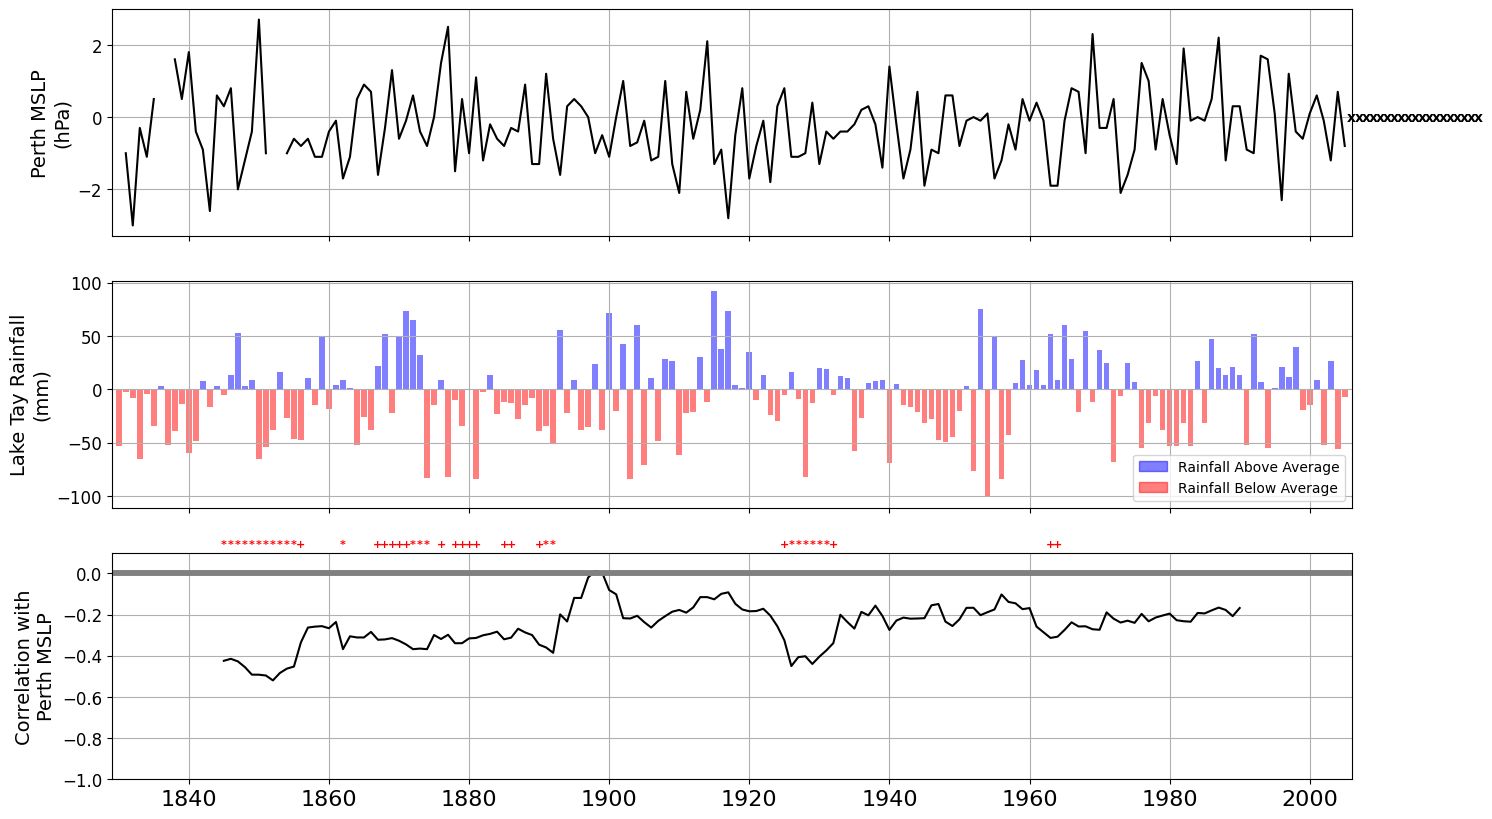

In [54]:
#Remove periods that have less then 5/7 of data avaliable
P_Ext_Winter_MSLP = ChatJR.filter_dataframe_by_months(P_MSLP[0], [3, 4, 5, 6, 7, 8, 9])
P= P_Ext_Winter_MSLP.resample('D').mean().resample('YS').count()
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.resample('YS').mean().round(1)
P_Ext_Winter_MSLP[P['MSLP'] < 153] = np.nan #TWO MONTHS OF MISSING DATA
P_Ext_Winter_MSLP.loc['1830'] = np.nan


#Add the raindays for 76-79 and mslp
P_Ext_Winter_MSLP_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').mean().round(0)
#Combime
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.combine_first(P_Ext_Winter_MSLP_76_79).round(1)

#Anomalies
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP[['MSLP']].round(1) - P_Ext_Winter_MSLP['MSLP'].loc['1961':'1990'].mean().round(1)
LT_RF_ANOM = LT_RF[['Mar_Sept_Rainfall']].round(1) - LT_RF['Mar_Sept_Rainfall'].loc['1961':'1990'].mean().round(1)

#save RD Anomalies

#Combine Lake Tay Rainfall with Raindays and Rainfall
combined = pd.concat([LT_RF_ANOM, P_Ext_Winter_MSLP], axis=1).loc[:'2005']
combined['Year'] = combined.index.year


#Now lets plot the figures
fig,axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
ax = axes[0]
#Plot 1 tells us the fluctuations
ax.plot(combined['Year'], combined['MSLP'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1829, 2006)
ax.set_ylabel('Perth MSLP (hPa)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

ax = axes[1]
#Plot 1 tells us the fluctuations
#Get the red and blue color plot
colors = ['blue' if val > 0 else 'red' for val in combined['Mar_Sept_Rainfall'].loc[:'2005']]
#Add the bar plot with the color scheme
ax.bar(combined['Year'], combined['Mar_Sept_Rainfall'], color=colors, alpha=0.5, width=0.8)
#Set the x bounds
ax.set_xlim(1829, 2006)
#Set the labels and parameters
ax.set_ylabel('Lake Tay Rainfall (mm)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#For the legend
blue_patch = mpatches.Patch(color='blue', label='Rainfall Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rainfall Below Average', alpha=0.5)
# Combine all legend items, including the custom color patches
all_handles = [blue_patch, red_patch]
all_labels = ['Rainfall Above Average', 'Rainfall Below Average']
# Show the combined legend
ax.legend(all_handles, all_labels, loc='lower right', frameon=True,fontsize = 10)
















LT_P_MSLP = ChatJR.running_correlation_with_p(combined, 'MSLP', 'Mar_Sept_Rainfall',31)



LT_P_MSLP['Year'] = LT_P_MSLP.index.year
ax = axes[2]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_MSLP['Year'], LT_P_MSLP['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1829, 2006)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='grey', linestyle='-', linewidth=4)
ax.axhline(y = 0, color='grey', linestyle='-', linewidth=4)
ax.axhline(y = 1, color='grey', linestyle='-', linewidth=4)
ax.set_ylim(-1,0.1)

X = 0.165
for idx, row in LT_P_MSLP.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='top', color='red', fontsize=8, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

axes[0].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[1].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[2].tick_params(axis='y', labelcolor='black', labelsize=12)

axes[0].set_ylabel('Perth MSLP\n(hPa)', color='black', fontsize=14)
axes[1].set_ylabel('Lake Tay Rainfall\n(mm)', color='black', fontsize=14)
axes[2].set_ylabel('Correlation with\nPerth MSLP', color='black', fontsize=14)


for x in nan_locs:
    axes[0].text(x, 0, 'x', color='black', fontsize=10, ha='center', va='center', fontweight='bold')
nan_locs = combined[combined['MSLP'].isna()]['Year']


fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\S4_Perth_Lake_Tay_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\S4_Perth_Lake_Tay_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')



# 9. Figure 4. Cape Leeuwin and Cape Otway

In [55]:
'''Perth MSLP and Raindays'''
P_Winter = ChatJR.filter_dataframe_by_months(P_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean()
P_Winter_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [6,7,8]).resample('YS').mean()
P_Winter = P_Winter.combine_first(P_Winter_76_79).round(1)
CL_Winter = ChatJR.filter_dataframe_by_months(CL_MSLP[0], [6,7,8]).resample('D').mean().resample('YS').mean()
CO_Winter = ChatJR.filter_dataframe_by_months(CO_MSLP[0], [6,7,8]).resample('YS').mean()

P_Winter_Anom = P_Winter - P_Winter.loc['1961':'1990'].mean()
CL_Winter_Anom = CL_Winter - CL_Winter.loc['1961':'1990'].mean()
CO_Winter_Anom = CO_Winter - CO_Winter.loc['1961':'1990'].mean()

#Rename for corr_sig
P_Winter_Anom = P_Winter_Anom.rename(columns = {'MSLP':'PERTH'})
CL_Winter_Anom = CL_Winter_Anom.rename(columns = {'MSLP':'LEEUWIN'})
CO_Winter_Anom = CO_Winter_Anom.rename(columns = {'MSLP':'OTWAY'})


#Combine
PRESSURE_CL_P_ANOM = pd.concat([P_Winter_Anom,CL_Winter_Anom],axis=1).dropna()
PRESSURE_CO_P_ANOM = pd.concat([P_Winter_Anom,CO_Winter_Anom],axis=1).dropna()


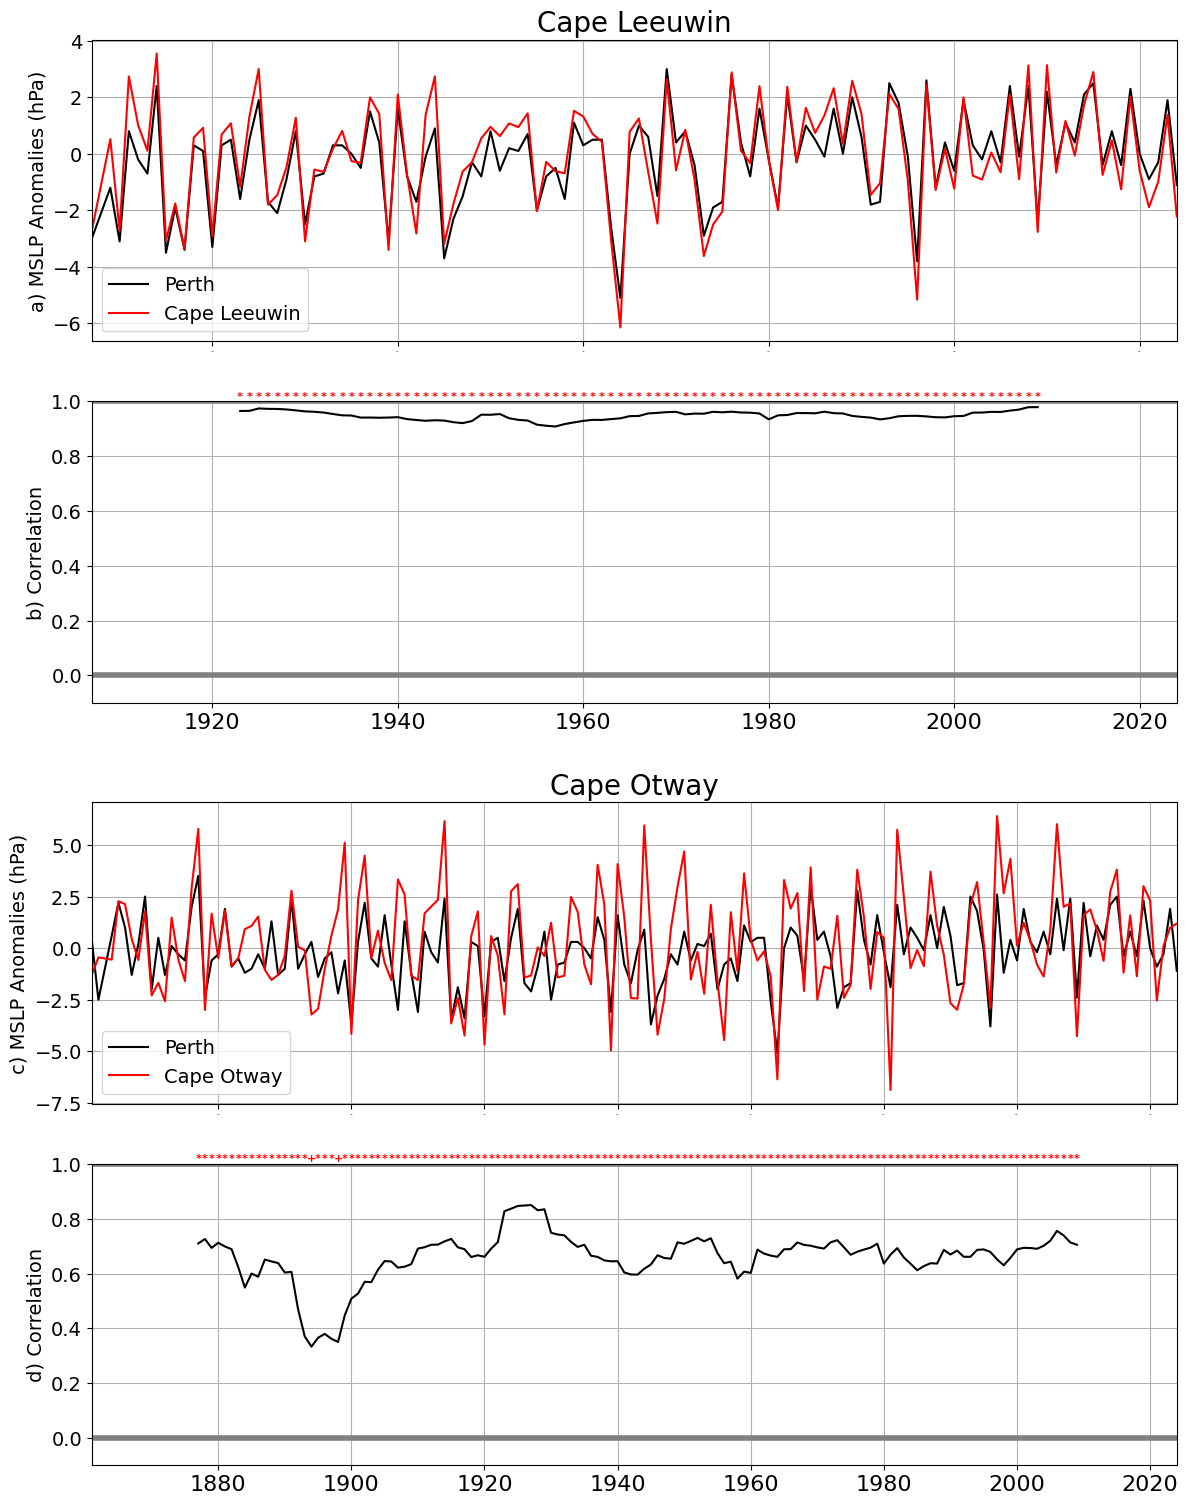

In [56]:

#Create the figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 18))


###ANOM CHARTS
ax1.set_title('Cape Leeuwin',fontsize = 20)
ax1.plot(PRESSURE_CL_P_ANOM['PERTH'], color='black', label='Perth')
ax1.plot(PRESSURE_CL_P_ANOM['LEEUWIN'], color='red', label='Cape Leeuwin')
ax1.set_ylabel('a) MSLP Anomalies (hPa)', color='k', fontsize=14)
ax1.tick_params('y', colors='k',labelsize = 14)
ax1.tick_params('x', colors='k',labelsize = 0)
ax1.grid(True)

ax3.set_title('Cape Otway',fontsize = 20)
ax3.plot(PRESSURE_CO_P_ANOM['PERTH'], color='black', label='Perth')
ax3.plot(PRESSURE_CO_P_ANOM['OTWAY'], color='red', label='Cape Otway')
ax3.set_ylabel('c) MSLP Anomalies (hPa)', color='k', fontsize=14)
ax3.tick_params('y', colors='k',labelsize = 14)
ax3.tick_params('x', colors='k',labelsize = 0)
ax3.grid(True)

#### 11-YEAR RUNNING CORRELATION PLOTS
CL_P_Anom_Corr = ChatJR.running_correlation_with_p(PRESSURE_CL_P_ANOM, 'PERTH', 'LEEUWIN', 31, 0.7)
CO_P_Anom_Corr = ChatJR.running_correlation_with_p(PRESSURE_CO_P_ANOM, 'PERTH', 'OTWAY', 31, 0.7)




# Plot the running correlation
ax2.plot(CL_P_Anom_Corr['correlation'], color='black', label='Pearson\'s r Correlation')

for idx, row in CL_P_Anom_Corr.iterrows():
    if row['significant'] == '90%':
        ax2.text(idx, 1, '+',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '95%':
        ax2.text(idx, 1, '*',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')    
    elif row['significant'] == '99%':
        ax2.text(idx, 1, '*',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')    
    else:
        pass  # or continue


# Axis and grid setup
ax2.set_ylabel('b) Correlation', color='k',fontsize =14)
ax2.tick_params('y', colors='k',labelsize =16)
ax2.grid(True)


# Reference lines
ax2.axhline(y=0, color='grey', linestyle='-', linewidth=4)
ax2.axhline(y=-1, color='grey', linestyle='-', linewidth=4)
ax2.axhline(y=1, color='grey', linestyle='-', linewidth=4)
ax2.tick_params('x', colors='k',labelsize =16)

# Set y-axis limits
ax2.set_ylim(0.8, 1)  # <-- slightly expanded y-limit so the top asterisks fit



# Plot the running correlation
ax4.plot(CO_P_Anom_Corr['correlation'], color='black', label='Pearson\'s r Correlation')

for idx, row in CO_P_Anom_Corr.iterrows():
    if row['significant'] == '90%':
        ax4.text(idx, 1, '+',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')
    elif row['significant'] == '95%':
        ax4.text(idx, 1, '*',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')    
    elif row['significant'] == '99%':
        ax4.text(idx, 1, '*',
                ha='center', va='bottom', color='red', fontsize=8, fontweight='bold')    
    else:
        pass  # or continue


# Axis and grid setup
ax4.set_ylabel('d) Correlation', color='k',fontsize =14)
ax4.tick_params('y', colors='k',labelsize =16)
ax4.grid(True)


# Reference lines
ax4.axhline(y=0, color='grey', linestyle='-', linewidth=4)
ax4.axhline(y=-1, color='grey', linestyle='-', linewidth=4)
ax4.axhline(y=1, color='grey', linestyle='-', linewidth=4)
ax4.tick_params('x', colors='k',labelsize =16)
ax4.tick_params('y', colors='k',labelsize =14)
ax2.tick_params('y', colors='k',labelsize =14)

# Set y-axis limits

ax1.set_xlim(PRESSURE_CL_P_ANOM.index.min(), PRESSURE_CL_P_ANOM.index.max())
ax2.set_xlim(PRESSURE_CL_P_ANOM.index.min(), PRESSURE_CL_P_ANOM.index.max())
ax3.set_xlim(PRESSURE_CO_P_ANOM.index.min(), PRESSURE_CO_P_ANOM.index.max())
ax4.set_xlim(PRESSURE_CO_P_ANOM.index.min(), PRESSURE_CO_P_ANOM.index.max())



# Get current positions
pos2 = ax2.get_position()
pos3 = ax3.get_position()


# Shift ax3 downward by ~0.0219 in figure coords (1 cm)
ax3.set_position([pos3.x0, pos3.y0 - 0.0219, pos3.width, pos3.height])
ax4.set_position([ax4.get_position().x0, ax4.get_position().y0 - 0.0219, ax4.get_position().width, ax4.get_position().height])



ax4.set_ylim(-0.1, 1)  # <-- slightly expanded y-limit so the top asterisks fit
ax2.set_ylim(-0.1, 1)  # <-- slightly expanded y-limit so the top asterisks fit

ax1.legend(fontsize = 14,loc = 'lower left')
ax3.legend(fontsize = 14,loc = 'lower left')

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\F4_JJA_Perth_Cape_Leeuwin_Cape_Otway_Anomaly_Comparisons_31Y.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\F4_JJA_Perth_Cape_Leeuwin_Cape_Otway_Anomaly_Comparisons_31Y.png", dpi=300, bbox_inches='tight')


# 10. SALMON GUMS

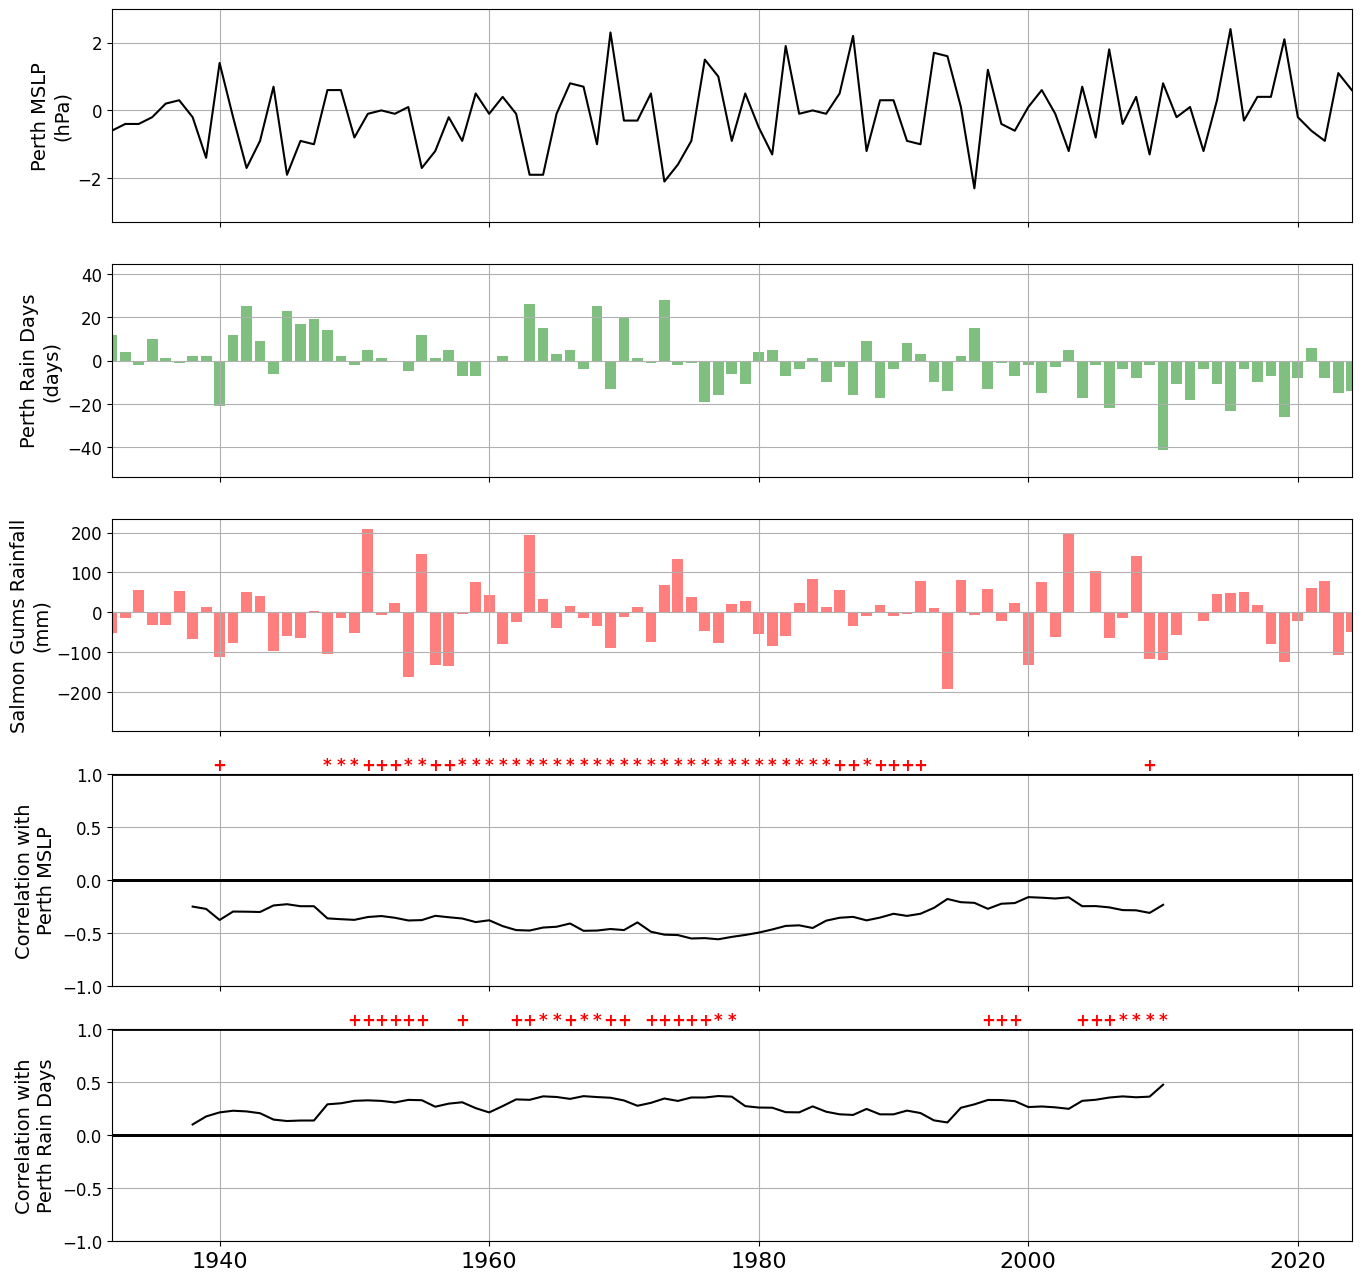

In [57]:
#Remove periods that have less then 5/7 of data avaliable
P_Ext_Winter_MSLP = ChatJR.filter_dataframe_by_months(P_MSLP[0], [3, 4, 5, 6, 7, 8, 9])
P= P_Ext_Winter_MSLP.resample('D').mean().resample('YS').count()
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.resample('YS').mean().round(1)
P_Ext_Winter_MSLP[P['MSLP'] < 153] = np.nan #TWO MONTHS OF MISSING DATA

#Remove raindays that are associacted with nans in mslp
P = P.rename(columns = {'MSLP':'RAINDAYS'})
P_Ext_Winter_RD = ChatJR.filter_dataframe_by_months(P_RD[0], [3, 4, 5, 6, 7, 8, 9])
P= P_Ext_Winter_RD.resample('YS').count()
P_Ext_Winter_RD = P_Ext_Winter_RD.resample('YS').sum().round(0)
P_Ext_Winter_RD[P['RAINDAYS'] < 153] = np.nan #TWO MONTHS OF MISSING DATA
#save RD
#P_Ext_Winter_RD.round(1).to_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_RAINDAYS_ANOMALIES_Extended_Winter_1830-2024.csv")

#Rainfall
P = P.rename(columns = {'RAINDAYS':'RAINFALL'})
P_Ext_Winter_RF = ChatJR.filter_dataframe_by_months(P_RF[0], [3, 4, 5, 6, 7, 8, 9])
P_Ext_Winter_RF = P_Ext_Winter_RF.resample('YS').sum().round(1).loc['1880':]
P_Ext_Winter_RF[P.loc['1880':]['RAINFALL'] < 153] = np.nan #Missing days of data removied


#Add the raindays for 76-79 and mslp
P_Ext_Winter_RD_76_79 = ChatJR.filter_dataframe_by_months(P_RD[1].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').sum().round(0)
P_Ext_Winter_MSLP_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').mean().round(0)
#Combime
P_Ext_Winter_RD = P_Ext_Winter_RD.combine_first(P_Ext_Winter_RD_76_79).round(1)
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.combine_first(P_Ext_Winter_MSLP_76_79).round(1)

#Anomalies
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP[['MSLP']].round(1) - P_Ext_Winter_MSLP['MSLP'].loc['1961':'1990'].mean().round(1)
P_Ext_Winter_RD = P_Ext_Winter_RD[['RAINDAYS']].round(0) - P_Ext_Winter_RD['RAINDAYS'].loc['1961':'1990'].mean().round(0)
P_Ext_Winter_RF = P_Ext_Winter_RF[['RAINFALL']].round(1) - P_Ext_Winter_RF['RAINFALL'].loc['1961':'1990'].mean().round(1)




SG_RF_ANOM = SG_RF[1].resample('YS').sum()[['Rainfall']].round(1) - SG_RF[1][['Rainfall']].resample('YS').sum().loc['1961':'1990'].mean().round(1)

#Combine Lake Tay Rainfall with Raindays and Rainfall
combined = pd.concat([SG_RF_ANOM, P_Ext_Winter_MSLP,P_Ext_Winter_RD,P_Ext_Winter_RF], axis=1)


#Get year out so we can compare with box
combined['Year'] = combined.index.year


#Now lets plot the figures
fig,axes = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

ax = axes[0]
#Plot 1 tells us the fluctuations
ax.plot(combined['Year'], combined['MSLP'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Perth MSLP (hPa)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

ax = axes[1]
#Plot 1 tells us the fluctuations
ax.bar(combined['Year'], combined['RAINDAYS'], color='green', alpha=0.5, width=0.8, label='Rainfall')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Perth Rain Days (days)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)

ax.grid()


ax = axes[2]
#Plot 1 tells us the fluctuations
ax.bar(combined['Year'], combined['Rainfall'], color='red', alpha=0.5, width=0.8, label='Rainfall')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Lake Tay Rainfall (mm)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()


LT_P_MSLP = ChatJR.running_correlation_with_p(combined, 'MSLP', 'Rainfall',31)
LT_P_RD = ChatJR.running_correlation_with_p(combined, 'Rainfall', 'RAINDAYS',31)
LT_P_RF = ChatJR.running_correlation_with_p(combined, 'Rainfall', 'RAINFALL',31)

LT_P_MSLP['Year'] = LT_P_MSLP.index.year
ax = axes[3]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_MSLP['Year'], LT_P_MSLP['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
#ax.axhline(y = -0.2, color='grey', linestyle='-', linewidth=2)
#ax.axhline(y = 0.2, color='grey', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,1)

X = 1
for idx, row in LT_P_MSLP.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()


LT_P_RD['Year'] = LT_P_RD.index.year
ax = axes[4]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_RD['Year'], LT_P_RD['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1932, 2024)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
#ax.axhline(y = -0.2, color='grey', linestyle='-', linewidth=2)
#ax.axhline(y = 0.2, color='grey', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,1)

X = 1
for idx, row in LT_P_RD.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

axes[0].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[1].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[2].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[3].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[4].tick_params(axis='y', labelcolor='black', labelsize=12)

axes[0].set_ylabel('Perth MSLP\n(hPa)', color='black', fontsize=14)
axes[1].set_ylabel('Perth Rain Days\n(days)', color='black', fontsize=14)
axes[2].set_ylabel('Salmon Gums Rainfall\n(mm)', color='black', fontsize=14)
axes[3].set_ylabel('Correlation with\nPerth MSLP', color='black', fontsize=14)
axes[4].set_ylabel('Correlation with\nPerth Rain Days', color='black', fontsize=14)


fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\MAMJJAS_Perth_Salmon_Gums_31Y_Comparisons.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\MAMJJAS_Perth_Salmon_Gums_31Y_Comparisons.png", dpi=300, bbox_inches='tight')


# 11. Supplement Update with Salmon Gardens and Lake Tay

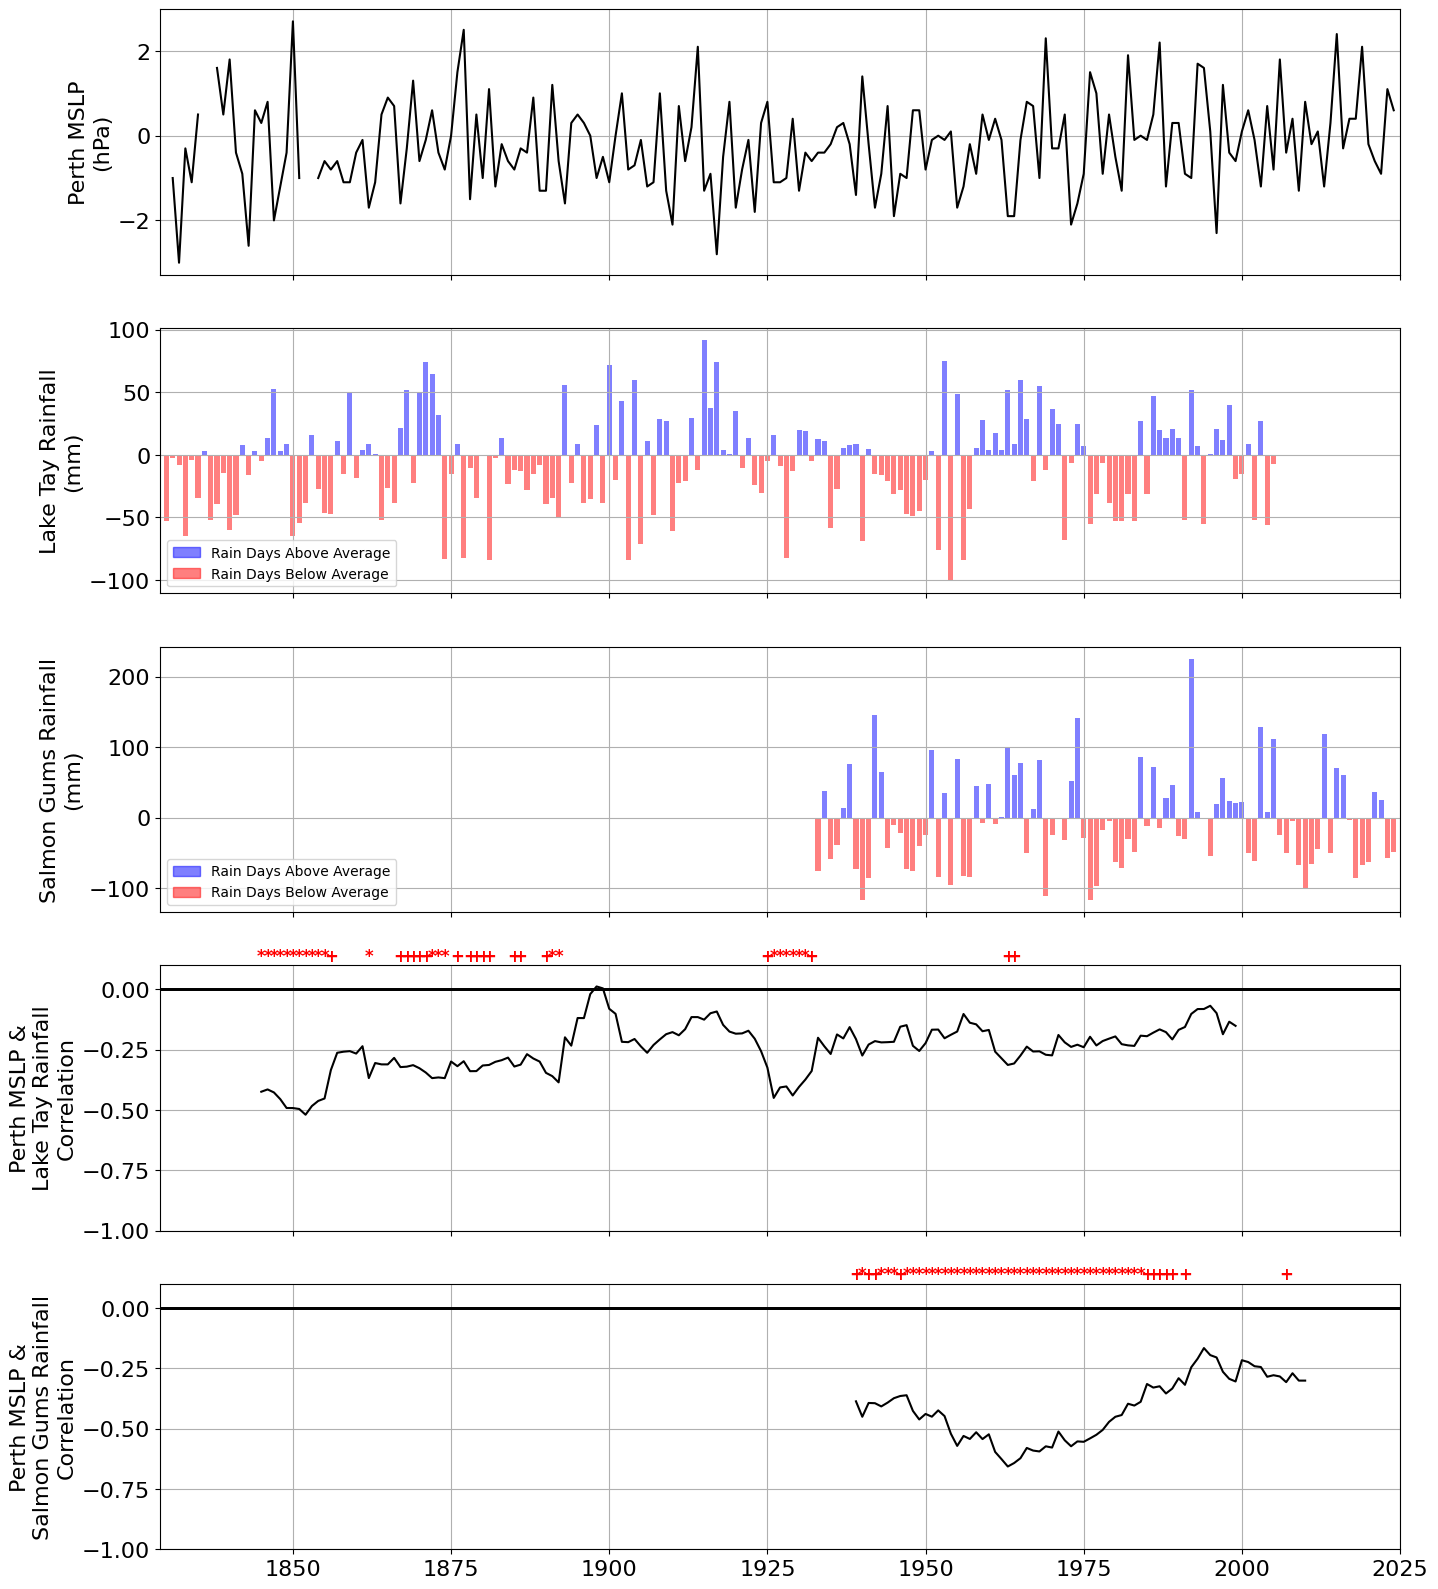

In [101]:
#So lets get the MSLP Anonamly
#Remove periods that have less then 5/7 of data avaliable
#Perth Winter MLSP
P_Ext_Winter_MSLP = ChatJR.filter_dataframe_by_months(P_MSLP[0], [3, 4, 5, 6, 7, 8, 9])
P= P_Ext_Winter_MSLP.resample('D').mean().resample('YS').count()
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.resample('YS').mean().round(1)
P_Ext_Winter_MSLP[P['MSLP'] < 153] = np.nan #TWO MONTHS OF MISSING DATA
#Add the MSLP for 76-79
P_Ext_Winter_MSLP_76_79 = ChatJR.filter_dataframe_by_months(P_MSLP[2].loc['1876':'1879'], [3, 4, 5, 6, 7, 8, 9]).resample('YS').mean().round(0)
#Combime
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.combine_first(P_Ext_Winter_MSLP_76_79).round(1)
#Anomalies
P_Ext_Winter_MSLP = P_Ext_Winter_MSLP[['MSLP']].round(1) - P_Ext_Winter_MSLP['MSLP'].loc['1961':'1990'].mean().round(1)

#Now Lake Tay
LT_RF_ANOM = LT_RF[['Mar_Sept_Rainfall']].round(1) - LT_RF['Mar_Sept_Rainfall'].loc['1961':'1990'].mean().round(1)

#Salmon Gums
SG_Ext_Winter_RF = ChatJR.filter_dataframe_by_months(SG_RF[0], [3, 4, 5, 6, 7, 8, 9]).dropna()
S = SG_Ext_Winter_RF.resample('YS').count()
SG_Ext_Winter_RF = SG_Ext_Winter_RF.resample('YS').sum().round(1)
SG_Ext_Winter_RF[S['Rainfall'] < 153] = np.nan #TWO MONTHS OF MISSING DATA

SG_Ext_Winter_RF = SG_Ext_Winter_RF[['Rainfall']].round(1) - SG_Ext_Winter_RF[['Rainfall']].loc['1961':'1990'].mean().round(1)


P_Ext_Winter_MSLP = P_Ext_Winter_MSLP.rename(columns = {'MSLP':'Perth MSLP'})
LT_RF_ANOM = LT_RF_ANOM.rename(columns = {'Mar_Sept_Rainfall':'Lake Tay Rainfall'})
SG_Ext_Winter_RF = SG_Ext_Winter_RF.rename(columns = {'Rainfall':'Salmon Gums Rainfall'})

#Combine Lake Tay Rainfall with Raindays and Rainfall
combined = pd.concat([P_Ext_Winter_MSLP, LT_RF_ANOM,SG_Ext_Winter_RF], axis=1)

#Get year out so we can compare with box
combined['Year'] = combined.index.year
combined

#Now lets plot the figures
fig,axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True)
ax = axes[0]
#Plot 1 tells us the fluctuations
ax.plot(combined['Year'], combined['Perth MSLP'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Perth MSLP\n(hPa)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#Lake Tay
ax = axes[1]
colors = ['blue' if val > 0 else 'red' for val in combined['Lake Tay Rainfall']]
ax.bar(combined['Year'], combined['Lake Tay Rainfall'], color=colors, alpha=0.5, width=0.8)
ax.set_xlim(1829, 2025)
ax.set_ylabel('Lake Tay Rainfall\n(mm)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#For the legend
blue_patch = mpatches.Patch(color='blue', label='Rain Days Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rain Days Below Average', alpha=0.5)
# Combine all legend items, including the custom color patches
all_handles = [blue_patch, red_patch]
all_labels = ['Rain Days Above Average', 'Rain Days Below Average']
# Show the combined legend
ax.legend(all_handles, all_labels, loc='lower left', frameon=True,fontsize = 10)

#Salmon Gums
ax = axes[2]
colors = ['blue' if val > 0 else 'red' for val in combined['Salmon Gums Rainfall']]
ax.bar(combined['Year'], combined['Salmon Gums Rainfall'], color=colors, alpha=0.5, width=0.8)
ax.set_xlim(1829, 2025)
ax.set_ylabel('Salmon Gums Rainfall\n(mm)', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.grid()

#For the legend
blue_patch = mpatches.Patch(color='blue', label='Rain Days Above Average', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Rain Days Below Average', alpha=0.5)
# Combine all legend items, including the custom color patches
all_handles = [blue_patch, red_patch]
all_labels = ['Rain Days Above Average', 'Rain Days Below Average']
# Show the combined legend
ax.legend(all_handles, all_labels, loc='lower left', frameon=True,fontsize = 10)

#correrations
LT_P_MSLP = ChatJR.running_correlation_with_p(combined, 'Perth MSLP', 'Lake Tay Rainfall',31)
SG_P_MSLP = ChatJR.running_correlation_with_p(combined, 'Perth MSLP', 'Salmon Gums Rainfall',31)
LT_P_MSLP['Year'] = LT_P_MSLP.index.year
SG_P_MSLP['Year'] = SG_P_MSLP.index.year

ax = axes[3]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_MSLP['Year'], LT_P_MSLP['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_ylabel('Perth MSLP &\nLake Tay Rainfall\nCorrelation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,0.1)

X = 0.1
for idx, row in LT_P_MSLP.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

ax = axes[4]
#Plot 1 tells us the fluctuations
line1, = ax.plot(SG_P_MSLP['Year'], SG_P_MSLP['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_ylabel('Perth MSLP &\nSalmon Gums Rainfall\nCorrelation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,0.1)

X = 0.1
for idx, row in SG_P_MSLP.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

fig.savefig(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\FIGURES\S4_Perth_Lake_Tay_Salmon_Gums_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')
fig.savefig(r"C:\Users\jarra\Dropbox\Perth pressure record 1830-2024\Figure files\Direct From Script\S4_Perth_Lake_Tay_Salmon_Gums_31Yr_Running_Correlation.png", dpi=300, bbox_inches='tight')



In [97]:









ax = axes[3]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_MSLP['Year'], LT_P_MSLP['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1830, 2005)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
#ax.axhline(y = -0.2, color='grey', linestyle='-', linewidth=2)
#ax.axhline(y = 0.2, color='grey', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,1)

X = 1
for idx, row in LT_P_MSLP.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()


LT_P_RD['Year'] = LT_P_RD.index.year
ax = axes[4]
#Plot 1 tells us the fluctuations
line1, = ax.plot(LT_P_RD['Year'], LT_P_RD['correlation'], linestyle='-', color='black', label='MSLP')
ax.set_xlim(1932, 2024)
ax.set_ylabel('Correlation', color='black', fontsize=16)
ax.tick_params(axis='y', labelcolor='black', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
ax.axhline(y = 0, color='black', linestyle='-', linewidth=2)
#ax.axhline(y = -0.2, color='grey', linestyle='-', linewidth=2)
#ax.axhline(y = 0.2, color='grey', linestyle='-', linewidth=2)
ax.axhline(y = 1, color='black', linestyle='-', linewidth=2)
ax.set_ylim(-1,1)

X = 1
for idx, row in LT_P_RD.iterrows():
    if row['significant'] == '90%':
        ax.text(row['Year'], X, '+',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '95%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')
    elif row['significant'] == '99%':
        ax.text(row['Year'], X, '*',
                ha='center', va='bottom', color='red', fontsize=12, fontweight='bold')    
    else:
        pass  # or continue
ax.grid()

axes[0].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[1].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[2].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[3].tick_params(axis='y', labelcolor='black', labelsize=12)
axes[4].tick_params(axis='y', labelcolor='black', labelsize=12)

axes[0].set_ylabel('Perth MSLP\n(hPa)', color='black', fontsize=14)
axes[1].set_ylabel('Perth Rain Days\n(days)', color='black', fontsize=14)
axes[2].set_ylabel('Salmon Gums Rainfall\n(mm)', color='black', fontsize=14)
axes[3].set_ylabel('Correlation with\nPerth MSLP', color='black', fontsize=14)
axes[4].set_ylabel('Correlation with\nPerth Rain Days', color='black', fontsize=14)



